## Import

In [34]:
import numpy as np
import pandas as pd
import pickle
from pingouin import welch_anova
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer, StandardScaler
from sklearn.decomposition import IncrementalPCA
import optuna
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier   

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings ; warnings.filterwarnings('ignore')

## Read data

In [35]:
msft, ma, intc, mcd, aapl = pd.read_pickle('data/total_data.pkl')
display(msft)

,log_return,MA5,MA20,UPPER,MID,LOW,KAMA,PSAR,ADX,DX,...,UNRATE,IR,ER,RS,TB,VIX,NASDAQ,OP,SP500,SOX
2014-01-02,-0.006705,37.220204,37.207492,38.803468,37.348500,35.893533,37.360475,35.805582,19.102528,5.789624,...,6.7,0.69,1.3670,424784.0,-339.861,14.23,4143.07,95.14,1831.979980,527.750000
2014-01-03,-0.006750,37.116803,37.179159,38.514914,37.247000,35.979087,37.334442,35.878159,18.975748,17.327611,...,6.7,0.69,1.3606,424784.0,-339.861,13.76,4131.91,93.66,1831.369995,526.679993
2014-01-06,-0.021359,36.787869,37.079239,38.460700,37.153500,35.846301,37.270533,35.947833,19.533921,26.790173,...,6.7,0.69,1.3636,424784.0,-339.861,13.55,4113.68,93.12,1826.770020,523.770020
2014-01-07,0.007720,36.661913,37.015502,38.276728,37.056000,35.835273,37.221169,36.014719,20.052225,26.790173,...,6.7,0.69,1.3618,424784.0,-339.861,12.92,4153.18,93.31,1837.880005,527.429993
2014-01-08,-0.018014,36.361274,36.895930,38.000257,36.908500,35.816743,37.073486,37.619999,21.295882,37.463426,...,6.7,0.69,1.3586,424784.0,-339.861,12.87,4165.61,91.90,1837.489990,535.760010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,-0.019349,334.216553,331.437732,345.132200,333.718500,322.304800,328.903193,351.470001,34.664443,13.242887,...,3.5,4.47,1.0910,694415.0,-935.445,14.25,13335.78,69.09,4328.819824,3515.770020
2023-06-27,0.018005,334.334371,331.736044,345.215302,333.802499,322.389697,328.936037,351.010401,33.139760,13.318881,...,3.5,4.47,1.0961,694415.0,-935.445,13.74,13555.67,67.68,4378.410156,3642.409912
2023-06-28,0.003819,334.839583,332.127850,345.415669,334.034500,322.653332,329.000745,350.559993,31.980083,16.904272,...,3.5,4.47,1.0904,694415.0,-935.445,13.43,13591.75,69.54,4376.859863,3609.479980
2023-06-29,-0.002385,334.909718,332.406149,345.454502,334.367499,323.280495,329.076456,350.118593,30.668172,13.613340,...,3.5,4.47,1.0881,694415.0,-935.445,13.54,13591.33,69.85,4396.439941,3614.179932


## Feature Engineering

## $\blacktriangleright$ Split Train-Test data

In [36]:
# Train : Test = 8 : 2로 쪼갠다
def splitData(DATA):
    train, test = DATA.iloc[:int(DATA.shape[0]*0.9)], DATA.iloc[int(DATA.shape[0]*0.9):]
    return train, test

In [37]:
msft_train, msft_test = splitData(msft)
ma_train, ma_test = splitData(ma)
intc_train, intc_test= splitData(intc)
mcd_train, mcd_test = splitData(mcd)
aapl_train, aapl_test = splitData(aapl)

print(f'train: {msft_train.index[0]} ~ {msft_train.index[-1]}')
print(f'test: {msft_test.index[0]} ~ {msft_test.index[-1]}')

train: 2014-01-02 00:00:00 ~ 2022-07-19 00:00:00
test: 2022-07-20 00:00:00 ~ 2023-06-30 00:00:00


## $\blacktriangleright$ Feature Selection

In [38]:
welch_test = pd.DataFrame(index=[i for i in msft_train.columns if i != 'target'], columns=['msft','ma','intc','mcd','aapl'])

for col in welch_test.index:
    ease = [welch_anova(dv=col, between='target', data=msft_train).values[-1][-1],
            welch_anova(dv=col, between='target', data=ma_train).values[-1][-1],
            welch_anova(dv=col, between='target', data=intc_train).values[-1][-1],
            welch_anova(dv=col, between='target', data=mcd_train).values[-1][-1],
            welch_anova(dv=col, between='target', data=aapl_train).values[-1][-1]]
    welch_test.loc[col] = ease

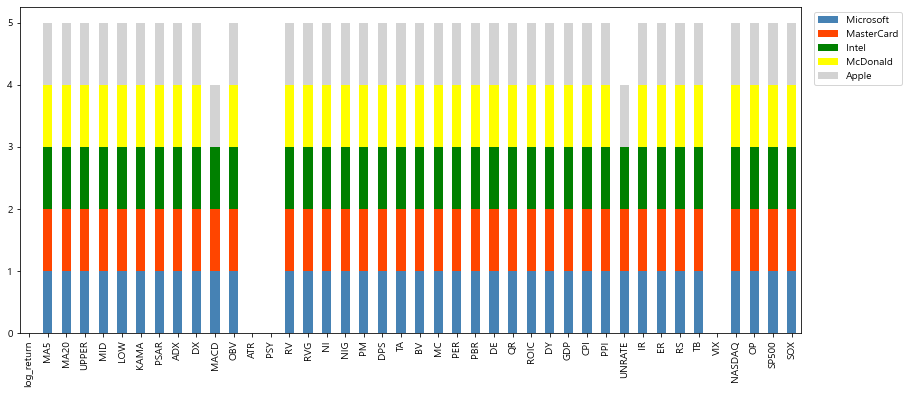

In [39]:
welch_test.applymap(lambda x: 1 if x < 0.05 else 0)\
.plot.bar(figsize=(14,6), stacked=True, color=['steelblue','orangered', 'green', 'yellow', 'lightgray'])
plt.legend(labels=['Microsoft', 'MasterCard', 'Intel', 'McDonald', 'Apple'], bbox_to_anchor=(1.01,1))
plt.show()

In [40]:
column = welch_test.index[welch_test.applymap(lambda x: 1 if x < 0.05 else 0).sum(axis=1)==5]
msft_x_train, msft_y_train, msft_x_test, msft_y_test= msft_train[column], msft_train['target'], msft_test[column], msft_test['target']
ma_x_train, ma_y_train, ma_x_test, ma_y_test= ma_train[column], ma_train['target'], ma_test[column], ma_test['target']
intc_x_train, intc_y_train, intc_x_test, intc_y_test= intc_train[column], intc_train['target'], intc_test[column], intc_test['target']
mcd_x_train, mcd_y_train, mcd_x_test, mcd_y_test= mcd_train[column], mcd_train['target'], mcd_test[column], mcd_test['target']
aapl_x_train, aapl_y_train, aapl_x_test, aapl_y_test= aapl_train[column], aapl_train['target'], aapl_test[column], aapl_test['target']

## $\blacktriangleright$ Scaling

In [41]:
def scaling(TRAIN, TEST):
    scaler = RobustScaler() # MinMaxScaler, RobustScaler, Normalizer, StandardScaler
    train = scaler.fit_transform(TRAIN)
    test = scaler.transform(TEST)
    return pd.DataFrame(train, index=TRAIN.index, columns=TRAIN.columns), pd.DataFrame(test, index=TEST.index, columns=TEST.columns)

In [42]:
msft_x_train, msft_x_test = scaling(msft_x_train, msft_x_test)
ma_x_train, ma_x_test = scaling(ma_x_train, ma_x_test)
intc_x_train, intc_x_test = scaling(intc_x_train, intc_x_test)
mcd_x_train, mcd_x_test = scaling(mcd_x_train, mcd_x_test)
aapl_x_train, aapl_x_test = scaling(aapl_x_train, aapl_x_test)
display(msft_x_train)

,MA5,MA20,UPPER,MID,LOW,KAMA,PSAR,ADX,DX,OBV,...,CPI,PPI,IR,ER,RS,TB,NASDAQ,OP,SP500,SOX
2014-01-02,-0.430715,-0.435236,-0.418319,-0.426866,-0.414095,-0.438363,-0.432609,-0.256960,-0.567629,-0.494869,...,-0.821614,0.485507,-0.408602,2.952866,-0.889275,0.997798,-0.632192,1.723315,-0.730738,-0.604036
2014-01-03,-0.431498,-0.435455,-0.420386,-0.427642,-0.413425,-0.438568,-0.432065,-0.267324,-0.112540,-0.510837,...,-0.821614,0.485507,-0.408602,2.871338,-0.889275,0.997798,-0.634580,1.657901,-0.731275,-0.604900
2014-01-06,-0.433989,-0.436229,-0.420774,-0.428358,-0.414465,-0.439071,-0.431543,-0.221696,0.260689,-0.533201,...,-0.821614,0.485507,-0.408602,2.909554,-0.889275,0.997798,-0.638480,1.634033,-0.735320,-0.607251
2014-01-07,-0.434943,-0.436723,-0.422092,-0.429105,-0.414551,-0.439460,-0.431041,-0.179328,0.260689,-0.514838,...,-0.821614,0.485507,-0.408602,2.886624,-0.889275,0.997798,-0.630030,1.642431,-0.725549,-0.604294
2014-01-08,-0.437221,-0.437649,-0.424072,-0.430234,-0.414696,-0.440622,-0.419006,-0.077667,0.681671,-0.545596,...,-0.821614,0.485507,-0.408602,2.845860,-0.889275,0.997798,-0.627371,1.580110,-0.725892,-0.597566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-13,1.244894,1.292800,1.255341,1.260752,1.208365,1.414136,1.316250,-0.582660,0.145353,0.925536,...,2.244207,5.112029,2.322581,-1.619108,2.435054,-1.814462,0.887621,1.869171,1.001693,1.051405
2022-07-14,1.233885,1.288218,1.250205,1.264422,1.221485,1.411562,1.313109,-0.512631,0.273371,0.938411,...,2.244207,5.112029,2.322581,-1.686624,2.435054,-1.814462,0.888393,1.840442,0.991667,1.091434
2022-07-15,1.233211,1.286021,1.249749,1.266321,1.225866,1.410286,1.306301,-0.521546,-0.226119,0.953681,...,2.244207,5.112029,2.322581,-1.608917,2.435054,-1.814462,0.931441,1.920000,1.055676,1.145428
2022-07-18,1.226525,1.282210,1.243299,1.269872,1.240180,1.407591,1.299765,-0.515201,-0.127339,0.942924,...,2.244207,5.112029,2.322581,-1.518471,2.435054,-1.814462,0.911681,2.136133,1.027260,1.133959


## Reshape

In [43]:
def ReshapeByStep(DATA, Y, STEP):
    y = Y.iloc[STEP:]
    ease = []
    for i in range(DATA.shape[0] - STEP):
        ease.append(DATA[i:i+STEP].values)
    # STEP일간 데이터 추출 후 2차원 배열화    
    x = np.reshape(np.array(ease).T, ((DATA.shape[0] - STEP),-1))
    return x, y

In [44]:
msft_x_train, msft_y_train = ReshapeByStep(msft_x_train, msft_y_train, 15)
msft_x_test, msft_y_test = ReshapeByStep(msft_x_test, msft_y_test, 15)

ma_x_train, ma_y_train = ReshapeByStep(ma_x_train, ma_y_train, 15)
ma_x_test, ma_y_test = ReshapeByStep(ma_x_test, ma_y_test, 15)

intc_x_train, intc_y_train = ReshapeByStep(intc_x_train, intc_y_train, 15)
intc_x_test, intc_y_test = ReshapeByStep(intc_x_test, intc_y_test, 15)

mcd_x_train, mcd_y_train = ReshapeByStep(mcd_x_train, mcd_y_train, 15)
mcd_x_test, mcd_y_test = ReshapeByStep(mcd_x_test, mcd_y_test, 15)

aapl_x_train, aapl_y_train = ReshapeByStep(aapl_x_train, aapl_y_train, 15)
aapl_x_test, aapl_y_test = ReshapeByStep(aapl_x_test, aapl_y_test, 15)

## IPCA

In [45]:
def IPCA(TRAIN, TEST, N, BATCH):
    inc_pca = IncrementalPCA(n_components=N)
    # Batch 단위로 학습
    for batch_x in np.array_split(TRAIN, BATCH):
        inc_pca.partial_fit(batch_x)
        
    train = inc_pca.transform(TRAIN)
    test = inc_pca.transform(TEST)
    return train, test

In [46]:
# index 일자의 수익변화 예측
msft_x_train, msft_x_test = IPCA(msft_x_train, msft_x_test, 10, 128)
msft_x_train = pd.DataFrame(msft_x_train, index=msft_y_train.index)
msft_x_test = pd.DataFrame(msft_x_test, index=msft_y_test.index)

ma_x_train, ma_x_test = IPCA(ma_x_train, ma_x_test, 10, 128)
ma_x_train = pd.DataFrame(ma_x_train, index=ma_y_train.index)
ma_x_test = pd.DataFrame(ma_x_test, index=ma_y_test.index)

intc_x_train, intc_x_test = IPCA(intc_x_train, intc_x_test, 10, 128)
intc_x_train = pd.DataFrame(intc_x_train, index=intc_y_train.index)
intc_x_test = pd.DataFrame(intc_x_test, index=intc_y_test.index)

mcd_x_train, mcd_x_test = IPCA(mcd_x_train, mcd_x_test, 10, 128)
mcd_x_train = pd.DataFrame(mcd_x_train, index=mcd_y_train.index)
mcd_x_test = pd.DataFrame(mcd_x_test, index=mcd_y_test.index)

aapl_x_train, aapl_x_test = IPCA(aapl_x_train, aapl_x_test, 10, 128)
aapl_x_train = pd.DataFrame(aapl_x_train, index=aapl_y_train.index)
aapl_x_test = pd.DataFrame(aapl_x_test, index=aapl_y_test.index)

display(msft_x_train)

,0,1,2,3,4,5,6,7,8,9
2014-01-24,-11.175748,-0.029512,-2.401014,0.442138,0.665004,0.011574,-0.286995,-0.210043,-0.307601,-0.168665
2014-01-27,-7.392388,1.712980,-1.215425,0.544690,0.285961,0.153339,-0.116262,-0.040904,-0.114612,-0.045075
2014-01-28,3.024324,4.289748,1.396210,0.603316,-0.422709,0.726428,-0.232322,-0.137936,0.162152,0.221093
2014-01-29,25.237259,4.963252,0.270405,-4.039771,1.663029,-2.098188,-1.293763,2.139626,-2.239291,-2.542887
2014-01-30,-11.057172,-0.033989,-2.273368,0.423192,0.750305,0.024044,-0.311610,-0.021911,-0.437800,-0.110053
...,...,...,...,...,...,...,...,...,...,...
2022-07-13,28.354982,10.589220,1.142280,1.017939,0.282501,-1.632883,-0.615670,0.339844,-0.511158,0.981775
2022-07-14,-13.213391,-2.251253,-1.396769,-2.408249,-0.956229,-1.403828,1.709117,2.393376,1.963022,-2.071033
2022-07-15,-8.402250,3.715824,-1.698702,0.909556,0.353654,0.292140,-0.286555,-0.075272,-0.171346,-0.031049
2022-07-18,0.539087,3.061301,1.115269,-0.385874,-0.235013,-0.166768,-1.078675,0.013189,-0.032227,-0.111843


## Modeling

In [43]:
target_dist = pd.concat([msft_y_train.value_counts(normalize=True),
                         ma_y_train.value_counts(normalize=True),
                         intc_y_train.value_counts(normalize=True),
                         mcd_y_train.value_counts(normalize=True),
                         aapl_y_train.value_counts(normalize=True)], axis=1)
target_dist.columns = ['Microsoft', 'MasterCard', 'Intel', 'McDonald', 'Apple']
target_dist

,Microsoft,MasterCard,Intel,McDonald,Apple
1.0,0.299625,0.323970,0.284644,0.392322,0.274345
-1.0,0.282303,0.256554,0.256554,0.339888,0.276685
2.0,0.152154,0.141854,0.141854,0.102528,0.155899
-2.0,0.102528,0.104401,0.122659,0.096442,0.099251
3.0,0.088951,0.085206,0.098315,0.038390,0.101124
-3.0,0.074438,0.088015,0.095974,0.030431,0.092697


## $\blacktriangleright$ Catboost

- Microsoft

In [74]:
model = CatBoostClassifier(iterations=800,
                           learning_rate=0.03,
                           bootstrap_type ='Bayesian',
                           objective='MultiClass',
                           random_state=2023)

In [75]:
model.fit(msft_x_train, msft_y_train, early_stopping_rounds = 300)

0:	learn: 1.7834020	total: 8.35ms	remaining: 6.67s
1:	learn: 1.7750906	total: 18.5ms	remaining: 7.36s
2:	learn: 1.7671417	total: 30ms	remaining: 7.96s
3:	learn: 1.7597527	total: 39.5ms	remaining: 7.87s
4:	learn: 1.7525056	total: 48.5ms	remaining: 7.71s
5:	learn: 1.7457196	total: 60.2ms	remaining: 7.97s
6:	learn: 1.7392223	total: 69.4ms	remaining: 7.86s
7:	learn: 1.7332226	total: 78.1ms	remaining: 7.74s
8:	learn: 1.7273764	total: 86.7ms	remaining: 7.62s
9:	learn: 1.7215365	total: 95.8ms	remaining: 7.57s
10:	learn: 1.7158675	total: 105ms	remaining: 7.51s
11:	learn: 1.7102558	total: 113ms	remaining: 7.45s
12:	learn: 1.7051641	total: 123ms	remaining: 7.46s
13:	learn: 1.7002877	total: 132ms	remaining: 7.42s
14:	learn: 1.6959152	total: 141ms	remaining: 7.39s
15:	learn: 1.6914013	total: 150ms	remaining: 7.35s
16:	learn: 1.6867834	total: 159ms	remaining: 7.33s
17:	learn: 1.6827493	total: 168ms	remaining: 7.29s
18:	learn: 1.6786380	total: 177ms	remaining: 7.26s
19:	learn: 1.6739982	total: 186ms

161:	learn: 1.4598341	total: 1.55s	remaining: 6.09s
162:	learn: 1.4586153	total: 1.55s	remaining: 6.08s
163:	learn: 1.4577374	total: 1.56s	remaining: 6.07s
164:	learn: 1.4571815	total: 1.57s	remaining: 6.06s
165:	learn: 1.4566002	total: 1.58s	remaining: 6.05s
166:	learn: 1.4556187	total: 1.59s	remaining: 6.04s
167:	learn: 1.4545951	total: 1.6s	remaining: 6.03s
168:	learn: 1.4538090	total: 1.61s	remaining: 6.02s
169:	learn: 1.4528976	total: 1.62s	remaining: 6.01s
170:	learn: 1.4520356	total: 1.63s	remaining: 6s
171:	learn: 1.4514182	total: 1.64s	remaining: 5.99s
172:	learn: 1.4507753	total: 1.65s	remaining: 5.97s
173:	learn: 1.4492639	total: 1.66s	remaining: 5.96s
174:	learn: 1.4479746	total: 1.67s	remaining: 5.95s
175:	learn: 1.4470645	total: 1.67s	remaining: 5.93s
176:	learn: 1.4461515	total: 1.68s	remaining: 5.93s
177:	learn: 1.4453364	total: 1.69s	remaining: 5.92s
178:	learn: 1.4443821	total: 1.7s	remaining: 5.91s
179:	learn: 1.4437162	total: 1.71s	remaining: 5.89s
180:	learn: 1.443

323:	learn: 1.3212639	total: 3.08s	remaining: 4.52s
324:	learn: 1.3207633	total: 3.09s	remaining: 4.51s
325:	learn: 1.3193936	total: 3.1s	remaining: 4.51s
326:	learn: 1.3185700	total: 3.11s	remaining: 4.5s
327:	learn: 1.3180101	total: 3.12s	remaining: 4.49s
328:	learn: 1.3167207	total: 3.13s	remaining: 4.48s
329:	learn: 1.3158310	total: 3.14s	remaining: 4.47s
330:	learn: 1.3152972	total: 3.15s	remaining: 4.46s
331:	learn: 1.3149837	total: 3.15s	remaining: 4.45s
332:	learn: 1.3141097	total: 3.17s	remaining: 4.44s
333:	learn: 1.3136978	total: 3.17s	remaining: 4.43s
334:	learn: 1.3133570	total: 3.18s	remaining: 4.42s
335:	learn: 1.3126685	total: 3.19s	remaining: 4.41s
336:	learn: 1.3111915	total: 3.2s	remaining: 4.4s
337:	learn: 1.3107847	total: 3.21s	remaining: 4.39s
338:	learn: 1.3096001	total: 3.22s	remaining: 4.38s
339:	learn: 1.3089016	total: 3.23s	remaining: 4.37s
340:	learn: 1.3079569	total: 3.24s	remaining: 4.36s
341:	learn: 1.3074387	total: 3.25s	remaining: 4.35s
342:	learn: 1.30

485:	learn: 1.2045931	total: 4.61s	remaining: 2.98s
486:	learn: 1.2038961	total: 4.62s	remaining: 2.97s
487:	learn: 1.2033356	total: 4.63s	remaining: 2.96s
488:	learn: 1.2020983	total: 4.64s	remaining: 2.95s
489:	learn: 1.2015498	total: 4.65s	remaining: 2.94s
490:	learn: 1.2010549	total: 4.66s	remaining: 2.93s
491:	learn: 1.2004450	total: 4.67s	remaining: 2.92s
492:	learn: 1.1993631	total: 4.67s	remaining: 2.91s
493:	learn: 1.1985494	total: 4.68s	remaining: 2.9s
494:	learn: 1.1975617	total: 4.69s	remaining: 2.89s
495:	learn: 1.1970905	total: 4.7s	remaining: 2.88s
496:	learn: 1.1961205	total: 4.71s	remaining: 2.87s
497:	learn: 1.1954569	total: 4.72s	remaining: 2.86s
498:	learn: 1.1946672	total: 4.73s	remaining: 2.85s
499:	learn: 1.1939731	total: 4.74s	remaining: 2.84s
500:	learn: 1.1932201	total: 4.75s	remaining: 2.83s
501:	learn: 1.1926441	total: 4.76s	remaining: 2.82s
502:	learn: 1.1917785	total: 4.77s	remaining: 2.81s
503:	learn: 1.1912944	total: 4.78s	remaining: 2.81s
504:	learn: 1.

660:	learn: 1.0888756	total: 6.3s	remaining: 1.32s
661:	learn: 1.0881126	total: 6.31s	remaining: 1.32s
662:	learn: 1.0874102	total: 6.32s	remaining: 1.31s
663:	learn: 1.0867935	total: 6.33s	remaining: 1.3s
664:	learn: 1.0862276	total: 6.34s	remaining: 1.29s
665:	learn: 1.0855249	total: 6.36s	remaining: 1.28s
666:	learn: 1.0850978	total: 6.36s	remaining: 1.27s
667:	learn: 1.0844748	total: 6.37s	remaining: 1.26s
668:	learn: 1.0839992	total: 6.38s	remaining: 1.25s
669:	learn: 1.0831275	total: 6.39s	remaining: 1.24s
670:	learn: 1.0826690	total: 6.4s	remaining: 1.23s
671:	learn: 1.0824392	total: 6.41s	remaining: 1.22s
672:	learn: 1.0818147	total: 6.42s	remaining: 1.21s
673:	learn: 1.0815157	total: 6.43s	remaining: 1.2s
674:	learn: 1.0811106	total: 6.44s	remaining: 1.19s
675:	learn: 1.0802786	total: 6.45s	remaining: 1.18s
676:	learn: 1.0794457	total: 6.46s	remaining: 1.17s
677:	learn: 1.0789812	total: 6.47s	remaining: 1.16s
678:	learn: 1.0784505	total: 6.48s	remaining: 1.15s
679:	learn: 1.07

In [76]:
print('정확도:', model.score(msft_x_test, msft_y_test))

정확도: 0.21428571428571427


- MasterCard

In [89]:
model = CatBoostClassifier(iterations=800,
                           learning_rate=0.03,
                           bootstrap_type ='Bayesian',
                           objective='MultiClass',
                           random_state=2023)

In [90]:
model.fit(ma_x_train, ma_y_train, early_stopping_rounds = 300)

0:	learn: 1.7831252	total: 9.19ms	remaining: 7.34s
1:	learn: 1.7749448	total: 18.9ms	remaining: 7.53s
2:	learn: 1.7669678	total: 29.1ms	remaining: 7.74s
3:	learn: 1.7595998	total: 38.2ms	remaining: 7.6s
4:	learn: 1.7528177	total: 46.7ms	remaining: 7.43s
5:	learn: 1.7455668	total: 57.1ms	remaining: 7.55s
6:	learn: 1.7393037	total: 66.2ms	remaining: 7.5s
7:	learn: 1.7328171	total: 74.5ms	remaining: 7.38s
8:	learn: 1.7268663	total: 83.3ms	remaining: 7.32s
9:	learn: 1.7214675	total: 92.2ms	remaining: 7.28s
10:	learn: 1.7160232	total: 103ms	remaining: 7.4s
11:	learn: 1.7104728	total: 112ms	remaining: 7.36s
12:	learn: 1.7052853	total: 121ms	remaining: 7.35s
13:	learn: 1.7000480	total: 131ms	remaining: 7.35s
14:	learn: 1.6954213	total: 140ms	remaining: 7.33s
15:	learn: 1.6907690	total: 149ms	remaining: 7.32s
16:	learn: 1.6866242	total: 160ms	remaining: 7.36s
17:	learn: 1.6826446	total: 170ms	remaining: 7.37s
18:	learn: 1.6785986	total: 180ms	remaining: 7.39s
19:	learn: 1.6746179	total: 191ms	

168:	learn: 1.4494914	total: 2.39s	remaining: 8.92s
169:	learn: 1.4487331	total: 2.4s	remaining: 8.92s
170:	learn: 1.4474705	total: 2.42s	remaining: 8.91s
171:	learn: 1.4459318	total: 2.44s	remaining: 8.91s
172:	learn: 1.4446841	total: 2.46s	remaining: 8.9s
173:	learn: 1.4436293	total: 2.47s	remaining: 8.9s
174:	learn: 1.4423110	total: 2.49s	remaining: 8.89s
175:	learn: 1.4413282	total: 2.5s	remaining: 8.88s
176:	learn: 1.4406154	total: 2.52s	remaining: 8.87s
177:	learn: 1.4396514	total: 2.54s	remaining: 8.86s
178:	learn: 1.4383882	total: 2.55s	remaining: 8.85s
179:	learn: 1.4372449	total: 2.57s	remaining: 8.84s
180:	learn: 1.4363739	total: 2.59s	remaining: 8.85s
181:	learn: 1.4352097	total: 2.6s	remaining: 8.84s
182:	learn: 1.4342950	total: 2.62s	remaining: 8.84s
183:	learn: 1.4335191	total: 2.64s	remaining: 8.83s
184:	learn: 1.4325701	total: 2.65s	remaining: 8.82s
185:	learn: 1.4313067	total: 2.67s	remaining: 8.81s
186:	learn: 1.4304945	total: 2.68s	remaining: 8.8s
187:	learn: 1.4294

334:	learn: 1.3044972	total: 4.98s	remaining: 6.91s
335:	learn: 1.3035861	total: 4.99s	remaining: 6.9s
336:	learn: 1.3028330	total: 5.01s	remaining: 6.88s
337:	learn: 1.3012597	total: 5.02s	remaining: 6.87s
338:	learn: 1.3005272	total: 5.04s	remaining: 6.85s
339:	learn: 1.2999623	total: 5.05s	remaining: 6.84s
340:	learn: 1.2990508	total: 5.07s	remaining: 6.82s
341:	learn: 1.2983735	total: 5.08s	remaining: 6.81s
342:	learn: 1.2975732	total: 5.1s	remaining: 6.79s
343:	learn: 1.2971511	total: 5.11s	remaining: 6.78s
344:	learn: 1.2960873	total: 5.13s	remaining: 6.77s
345:	learn: 1.2953908	total: 5.14s	remaining: 6.75s
346:	learn: 1.2949090	total: 5.16s	remaining: 6.74s
347:	learn: 1.2942434	total: 5.18s	remaining: 6.73s
348:	learn: 1.2936043	total: 5.2s	remaining: 6.71s
349:	learn: 1.2928364	total: 5.21s	remaining: 6.7s
350:	learn: 1.2923231	total: 5.23s	remaining: 6.69s
351:	learn: 1.2915547	total: 5.24s	remaining: 6.67s
352:	learn: 1.2909883	total: 5.26s	remaining: 6.66s
353:	learn: 1.29

500:	learn: 1.1799105	total: 7.6s	remaining: 4.53s
501:	learn: 1.1793762	total: 7.61s	remaining: 4.52s
502:	learn: 1.1784486	total: 7.63s	remaining: 4.5s
503:	learn: 1.1780284	total: 7.64s	remaining: 4.49s
504:	learn: 1.1774176	total: 7.66s	remaining: 4.47s
505:	learn: 1.1765754	total: 7.67s	remaining: 4.46s
506:	learn: 1.1759377	total: 7.69s	remaining: 4.44s
507:	learn: 1.1753221	total: 7.71s	remaining: 4.43s
508:	learn: 1.1748350	total: 7.72s	remaining: 4.41s
509:	learn: 1.1739852	total: 7.73s	remaining: 4.4s
510:	learn: 1.1732058	total: 7.75s	remaining: 4.38s
511:	learn: 1.1724882	total: 7.76s	remaining: 4.37s
512:	learn: 1.1713935	total: 7.78s	remaining: 4.35s
513:	learn: 1.1710759	total: 7.79s	remaining: 4.33s
514:	learn: 1.1702571	total: 7.81s	remaining: 4.32s
515:	learn: 1.1695837	total: 7.82s	remaining: 4.3s
516:	learn: 1.1688825	total: 7.84s	remaining: 4.29s
517:	learn: 1.1679819	total: 7.85s	remaining: 4.27s
518:	learn: 1.1673831	total: 7.86s	remaining: 4.26s
519:	learn: 1.16

669:	learn: 1.0607748	total: 10.2s	remaining: 1.98s
670:	learn: 1.0604449	total: 10.2s	remaining: 1.96s
671:	learn: 1.0597802	total: 10.2s	remaining: 1.95s
672:	learn: 1.0593184	total: 10.2s	remaining: 1.93s
673:	learn: 1.0584898	total: 10.2s	remaining: 1.91s
674:	learn: 1.0577588	total: 10.3s	remaining: 1.9s
675:	learn: 1.0565662	total: 10.3s	remaining: 1.88s
676:	learn: 1.0558444	total: 10.3s	remaining: 1.87s
677:	learn: 1.0552878	total: 10.3s	remaining: 1.85s
678:	learn: 1.0546397	total: 10.3s	remaining: 1.84s
679:	learn: 1.0542102	total: 10.3s	remaining: 1.82s
680:	learn: 1.0536608	total: 10.3s	remaining: 1.81s
681:	learn: 1.0533037	total: 10.4s	remaining: 1.79s
682:	learn: 1.0524634	total: 10.4s	remaining: 1.78s
683:	learn: 1.0519360	total: 10.4s	remaining: 1.76s
684:	learn: 1.0512502	total: 10.4s	remaining: 1.75s
685:	learn: 1.0505479	total: 10.4s	remaining: 1.73s
686:	learn: 1.0499783	total: 10.4s	remaining: 1.72s
687:	learn: 1.0491875	total: 10.4s	remaining: 1.7s
688:	learn: 1.

In [91]:
print('정확도:', model.score(ma_x_test, ma_y_test))

정확도: 0.29910714285714285


- Intel

In [98]:
model = CatBoostClassifier(iterations=2000,
                           learning_rate=0.03,
                           bootstrap_type ='Bayesian',
                           objective='MultiClass',
                           random_state=2023)

In [99]:
model.fit(intc_x_train, intc_y_train, early_stopping_rounds = 300)

0:	learn: 1.7857073	total: 12.3ms	remaining: 24.5s
1:	learn: 1.7799042	total: 24.6ms	remaining: 24.6s
2:	learn: 1.7740217	total: 36.4ms	remaining: 24.2s
3:	learn: 1.7683309	total: 47ms	remaining: 23.4s
4:	learn: 1.7631639	total: 57.7ms	remaining: 23s
5:	learn: 1.7581520	total: 68.6ms	remaining: 22.8s
6:	learn: 1.7534780	total: 80ms	remaining: 22.8s
7:	learn: 1.7488967	total: 91.2ms	remaining: 22.7s
8:	learn: 1.7445251	total: 102ms	remaining: 22.6s
9:	learn: 1.7401084	total: 113ms	remaining: 22.6s
10:	learn: 1.7356006	total: 124ms	remaining: 22.4s
11:	learn: 1.7316555	total: 135ms	remaining: 22.4s
12:	learn: 1.7271755	total: 148ms	remaining: 22.6s
13:	learn: 1.7230087	total: 159ms	remaining: 22.6s
14:	learn: 1.7189550	total: 170ms	remaining: 22.5s
15:	learn: 1.7156508	total: 185ms	remaining: 22.9s
16:	learn: 1.7118424	total: 198ms	remaining: 23s
17:	learn: 1.7085089	total: 213ms	remaining: 23.4s
18:	learn: 1.7052469	total: 227ms	remaining: 23.7s
19:	learn: 1.7021441	total: 241ms	remaini

167:	learn: 1.4780596	total: 3.14s	remaining: 34.3s
168:	learn: 1.4771743	total: 3.16s	remaining: 34.3s
169:	learn: 1.4762861	total: 3.18s	remaining: 34.2s
170:	learn: 1.4755579	total: 3.2s	remaining: 34.2s
171:	learn: 1.4744738	total: 3.22s	remaining: 34.2s
172:	learn: 1.4732688	total: 3.24s	remaining: 34.2s
173:	learn: 1.4726592	total: 3.26s	remaining: 34.2s
174:	learn: 1.4712828	total: 3.27s	remaining: 34.1s
175:	learn: 1.4702094	total: 3.29s	remaining: 34.1s
176:	learn: 1.4690024	total: 3.31s	remaining: 34.1s
177:	learn: 1.4675574	total: 3.32s	remaining: 34s
178:	learn: 1.4664816	total: 3.33s	remaining: 33.9s
179:	learn: 1.4654582	total: 3.35s	remaining: 33.9s
180:	learn: 1.4642494	total: 3.36s	remaining: 33.8s
181:	learn: 1.4634555	total: 3.37s	remaining: 33.7s
182:	learn: 1.4623978	total: 3.39s	remaining: 33.6s
183:	learn: 1.4614494	total: 3.4s	remaining: 33.6s
184:	learn: 1.4606704	total: 3.42s	remaining: 33.6s
185:	learn: 1.4594527	total: 3.44s	remaining: 33.5s
186:	learn: 1.45

326:	learn: 1.3324488	total: 7.67s	remaining: 39.3s
327:	learn: 1.3314967	total: 7.69s	remaining: 39.2s
328:	learn: 1.3306800	total: 7.71s	remaining: 39.1s
329:	learn: 1.3300961	total: 7.73s	remaining: 39.1s
330:	learn: 1.3297384	total: 7.75s	remaining: 39.1s
331:	learn: 1.3283080	total: 7.77s	remaining: 39s
332:	learn: 1.3277387	total: 7.79s	remaining: 39s
333:	learn: 1.3269577	total: 7.81s	remaining: 39s
334:	learn: 1.3264010	total: 7.83s	remaining: 38.9s
335:	learn: 1.3254960	total: 7.85s	remaining: 38.9s
336:	learn: 1.3249981	total: 7.89s	remaining: 38.9s
337:	learn: 1.3246187	total: 7.91s	remaining: 38.9s
338:	learn: 1.3238383	total: 7.95s	remaining: 39s
339:	learn: 1.3234770	total: 7.97s	remaining: 38.9s
340:	learn: 1.3225621	total: 8.01s	remaining: 39s
341:	learn: 1.3219642	total: 8.02s	remaining: 38.9s
342:	learn: 1.3210336	total: 8.07s	remaining: 39s
343:	learn: 1.3204948	total: 8.09s	remaining: 39s
344:	learn: 1.3197305	total: 8.13s	remaining: 39s
345:	learn: 1.3189085	total:

486:	learn: 1.2086587	total: 15s	remaining: 46.6s
487:	learn: 1.2076676	total: 15.1s	remaining: 46.7s
488:	learn: 1.2071025	total: 15.1s	remaining: 46.7s
489:	learn: 1.2065103	total: 15.2s	remaining: 46.7s
490:	learn: 1.2058975	total: 15.2s	remaining: 46.7s
491:	learn: 1.2052571	total: 15.2s	remaining: 46.7s
492:	learn: 1.2043575	total: 15.3s	remaining: 46.7s
493:	learn: 1.2034952	total: 15.3s	remaining: 46.7s
494:	learn: 1.2028020	total: 15.4s	remaining: 46.7s
495:	learn: 1.2019703	total: 15.4s	remaining: 46.6s
496:	learn: 1.2015485	total: 15.4s	remaining: 46.7s
497:	learn: 1.2007504	total: 15.5s	remaining: 46.6s
498:	learn: 1.2000709	total: 15.5s	remaining: 46.6s
499:	learn: 1.1990556	total: 15.5s	remaining: 46.6s
500:	learn: 1.1984411	total: 15.6s	remaining: 46.6s
501:	learn: 1.1977233	total: 15.6s	remaining: 46.7s
502:	learn: 1.1966531	total: 15.7s	remaining: 46.7s
503:	learn: 1.1959619	total: 15.7s	remaining: 46.7s
504:	learn: 1.1951133	total: 15.8s	remaining: 46.7s
505:	learn: 1.

651:	learn: 1.0922988	total: 20.9s	remaining: 43.2s
652:	learn: 1.0918990	total: 20.9s	remaining: 43.2s
653:	learn: 1.0914690	total: 21s	remaining: 43.2s
654:	learn: 1.0906975	total: 21s	remaining: 43.1s
655:	learn: 1.0902198	total: 21s	remaining: 43s
656:	learn: 1.0895496	total: 21s	remaining: 43s
657:	learn: 1.0887700	total: 21s	remaining: 42.9s
658:	learn: 1.0879158	total: 21.1s	remaining: 42.9s
659:	learn: 1.0874511	total: 21.1s	remaining: 42.8s
660:	learn: 1.0868471	total: 21.1s	remaining: 42.7s
661:	learn: 1.0864525	total: 21.1s	remaining: 42.7s
662:	learn: 1.0858310	total: 21.1s	remaining: 42.6s
663:	learn: 1.0849299	total: 21.1s	remaining: 42.5s
664:	learn: 1.0843895	total: 21.2s	remaining: 42.5s
665:	learn: 1.0830644	total: 21.2s	remaining: 42.5s
666:	learn: 1.0822440	total: 21.2s	remaining: 42.4s
667:	learn: 1.0816274	total: 21.2s	remaining: 42.3s
668:	learn: 1.0810190	total: 21.2s	remaining: 42.3s
669:	learn: 1.0804479	total: 21.3s	remaining: 42.2s
670:	learn: 1.0798079	tota

817:	learn: 0.9852033	total: 24.7s	remaining: 35.7s
818:	learn: 0.9845661	total: 24.8s	remaining: 35.7s
819:	learn: 0.9840239	total: 24.8s	remaining: 35.6s
820:	learn: 0.9835313	total: 24.8s	remaining: 35.6s
821:	learn: 0.9828204	total: 24.8s	remaining: 35.6s
822:	learn: 0.9824501	total: 24.9s	remaining: 35.6s
823:	learn: 0.9815527	total: 24.9s	remaining: 35.5s
824:	learn: 0.9811827	total: 24.9s	remaining: 35.5s
825:	learn: 0.9808325	total: 24.9s	remaining: 35.5s
826:	learn: 0.9802802	total: 25s	remaining: 35.4s
827:	learn: 0.9796449	total: 25s	remaining: 35.4s
828:	learn: 0.9789307	total: 25s	remaining: 35.4s
829:	learn: 0.9781770	total: 25s	remaining: 35.3s
830:	learn: 0.9779217	total: 25.1s	remaining: 35.3s
831:	learn: 0.9773772	total: 25.1s	remaining: 35.2s
832:	learn: 0.9766593	total: 25.1s	remaining: 35.2s
833:	learn: 0.9759484	total: 25.1s	remaining: 35.1s
834:	learn: 0.9755471	total: 25.1s	remaining: 35.1s
835:	learn: 0.9750588	total: 25.2s	remaining: 35.1s
836:	learn: 0.974358

976:	learn: 0.8945456	total: 28.3s	remaining: 29.6s
977:	learn: 0.8939205	total: 28.3s	remaining: 29.5s
978:	learn: 0.8933016	total: 28.3s	remaining: 29.5s
979:	learn: 0.8929521	total: 28.3s	remaining: 29.5s
980:	learn: 0.8923575	total: 28.3s	remaining: 29.4s
981:	learn: 0.8919246	total: 28.4s	remaining: 29.4s
982:	learn: 0.8914942	total: 28.4s	remaining: 29.4s
983:	learn: 0.8909891	total: 28.4s	remaining: 29.3s
984:	learn: 0.8901579	total: 28.4s	remaining: 29.3s
985:	learn: 0.8896064	total: 28.5s	remaining: 29.3s
986:	learn: 0.8892545	total: 28.5s	remaining: 29.3s
987:	learn: 0.8885775	total: 28.5s	remaining: 29.2s
988:	learn: 0.8878317	total: 28.6s	remaining: 29.2s
989:	learn: 0.8874568	total: 28.6s	remaining: 29.1s
990:	learn: 0.8868791	total: 28.6s	remaining: 29.1s
991:	learn: 0.8862568	total: 28.6s	remaining: 29.1s
992:	learn: 0.8859837	total: 28.6s	remaining: 29s
993:	learn: 0.8855979	total: 28.6s	remaining: 29s
994:	learn: 0.8848558	total: 28.7s	remaining: 29s
995:	learn: 0.8843

1144:	learn: 0.8102758	total: 31.3s	remaining: 23.4s
1145:	learn: 0.8099538	total: 31.3s	remaining: 23.3s
1146:	learn: 0.8093761	total: 31.3s	remaining: 23.3s
1147:	learn: 0.8089603	total: 31.3s	remaining: 23.3s
1148:	learn: 0.8083551	total: 31.4s	remaining: 23.2s
1149:	learn: 0.8079635	total: 31.4s	remaining: 23.2s
1150:	learn: 0.8077517	total: 31.4s	remaining: 23.1s
1151:	learn: 0.8072431	total: 31.4s	remaining: 23.1s
1152:	learn: 0.8068111	total: 31.4s	remaining: 23.1s
1153:	learn: 0.8064373	total: 31.4s	remaining: 23s
1154:	learn: 0.8058672	total: 31.4s	remaining: 23s
1155:	learn: 0.8053555	total: 31.5s	remaining: 23s
1156:	learn: 0.8050669	total: 31.5s	remaining: 22.9s
1157:	learn: 0.8045903	total: 31.5s	remaining: 22.9s
1158:	learn: 0.8042491	total: 31.5s	remaining: 22.9s
1159:	learn: 0.8039685	total: 31.5s	remaining: 22.8s
1160:	learn: 0.8036837	total: 31.5s	remaining: 22.8s
1161:	learn: 0.8030949	total: 31.6s	remaining: 22.8s
1162:	learn: 0.8024979	total: 31.6s	remaining: 22.7s

1309:	learn: 0.7396882	total: 33.7s	remaining: 17.7s
1310:	learn: 0.7393373	total: 33.7s	remaining: 17.7s
1311:	learn: 0.7391677	total: 33.7s	remaining: 17.7s
1312:	learn: 0.7387147	total: 33.7s	remaining: 17.6s
1313:	learn: 0.7380644	total: 33.7s	remaining: 17.6s
1314:	learn: 0.7375745	total: 33.8s	remaining: 17.6s
1315:	learn: 0.7372435	total: 33.8s	remaining: 17.6s
1316:	learn: 0.7365811	total: 33.8s	remaining: 17.5s
1317:	learn: 0.7361556	total: 33.8s	remaining: 17.5s
1318:	learn: 0.7357392	total: 33.8s	remaining: 17.5s
1319:	learn: 0.7352385	total: 33.8s	remaining: 17.4s
1320:	learn: 0.7348298	total: 33.8s	remaining: 17.4s
1321:	learn: 0.7344104	total: 33.9s	remaining: 17.4s
1322:	learn: 0.7340114	total: 33.9s	remaining: 17.3s
1323:	learn: 0.7335775	total: 33.9s	remaining: 17.3s
1324:	learn: 0.7331573	total: 33.9s	remaining: 17.3s
1325:	learn: 0.7327949	total: 33.9s	remaining: 17.2s
1326:	learn: 0.7323917	total: 33.9s	remaining: 17.2s
1327:	learn: 0.7320147	total: 33.9s	remaining:

1478:	learn: 0.6741294	total: 36s	remaining: 12.7s
1479:	learn: 0.6737891	total: 36.1s	remaining: 12.7s
1480:	learn: 0.6733955	total: 36.1s	remaining: 12.6s
1481:	learn: 0.6731459	total: 36.1s	remaining: 12.6s
1482:	learn: 0.6728534	total: 36.1s	remaining: 12.6s
1483:	learn: 0.6724607	total: 36.1s	remaining: 12.6s
1484:	learn: 0.6720159	total: 36.1s	remaining: 12.5s
1485:	learn: 0.6717276	total: 36.1s	remaining: 12.5s
1486:	learn: 0.6714901	total: 36.2s	remaining: 12.5s
1487:	learn: 0.6711834	total: 36.2s	remaining: 12.4s
1488:	learn: 0.6706742	total: 36.2s	remaining: 12.4s
1489:	learn: 0.6702928	total: 36.2s	remaining: 12.4s
1490:	learn: 0.6699546	total: 36.2s	remaining: 12.4s
1491:	learn: 0.6696012	total: 36.2s	remaining: 12.3s
1492:	learn: 0.6692641	total: 36.2s	remaining: 12.3s
1493:	learn: 0.6688085	total: 36.3s	remaining: 12.3s
1494:	learn: 0.6684337	total: 36.3s	remaining: 12.3s
1495:	learn: 0.6680501	total: 36.3s	remaining: 12.2s
1496:	learn: 0.6676239	total: 36.3s	remaining: 1

1645:	learn: 0.6191472	total: 38.4s	remaining: 8.26s
1646:	learn: 0.6187271	total: 38.4s	remaining: 8.24s
1647:	learn: 0.6183292	total: 38.5s	remaining: 8.21s
1648:	learn: 0.6180062	total: 38.5s	remaining: 8.19s
1649:	learn: 0.6177643	total: 38.5s	remaining: 8.16s
1650:	learn: 0.6174122	total: 38.5s	remaining: 8.14s
1651:	learn: 0.6170902	total: 38.5s	remaining: 8.11s
1652:	learn: 0.6165151	total: 38.5s	remaining: 8.09s
1653:	learn: 0.6162952	total: 38.5s	remaining: 8.06s
1654:	learn: 0.6160613	total: 38.6s	remaining: 8.04s
1655:	learn: 0.6159322	total: 38.6s	remaining: 8.01s
1656:	learn: 0.6157357	total: 38.6s	remaining: 7.99s
1657:	learn: 0.6154851	total: 38.6s	remaining: 7.96s
1658:	learn: 0.6151616	total: 38.6s	remaining: 7.94s
1659:	learn: 0.6149763	total: 38.6s	remaining: 7.91s
1660:	learn: 0.6145938	total: 38.7s	remaining: 7.89s
1661:	learn: 0.6142569	total: 38.7s	remaining: 7.86s
1662:	learn: 0.6140848	total: 38.7s	remaining: 7.84s
1663:	learn: 0.6138207	total: 38.7s	remaining:

1806:	learn: 0.5730115	total: 40.8s	remaining: 4.36s
1807:	learn: 0.5727201	total: 40.8s	remaining: 4.33s
1808:	learn: 0.5724825	total: 40.8s	remaining: 4.31s
1809:	learn: 0.5721550	total: 40.8s	remaining: 4.29s
1810:	learn: 0.5717773	total: 40.9s	remaining: 4.26s
1811:	learn: 0.5713212	total: 40.9s	remaining: 4.24s
1812:	learn: 0.5710435	total: 40.9s	remaining: 4.22s
1813:	learn: 0.5707656	total: 40.9s	remaining: 4.19s
1814:	learn: 0.5705456	total: 40.9s	remaining: 4.17s
1815:	learn: 0.5703290	total: 40.9s	remaining: 4.15s
1816:	learn: 0.5700345	total: 40.9s	remaining: 4.12s
1817:	learn: 0.5696916	total: 41s	remaining: 4.1s
1818:	learn: 0.5694535	total: 41s	remaining: 4.08s
1819:	learn: 0.5692238	total: 41s	remaining: 4.05s
1820:	learn: 0.5689502	total: 41s	remaining: 4.03s
1821:	learn: 0.5687160	total: 41s	remaining: 4.01s
1822:	learn: 0.5684463	total: 41s	remaining: 3.98s
1823:	learn: 0.5680978	total: 41s	remaining: 3.96s
1824:	learn: 0.5678212	total: 41.1s	remaining: 3.94s
1825:	le

1974:	learn: 0.5284625	total: 43.4s	remaining: 550ms
1975:	learn: 0.5280663	total: 43.4s	remaining: 528ms
1976:	learn: 0.5277844	total: 43.5s	remaining: 506ms
1977:	learn: 0.5275977	total: 43.5s	remaining: 484ms
1978:	learn: 0.5273699	total: 43.5s	remaining: 462ms
1979:	learn: 0.5270186	total: 43.5s	remaining: 439ms
1980:	learn: 0.5266838	total: 43.5s	remaining: 417ms
1981:	learn: 0.5263861	total: 43.5s	remaining: 395ms
1982:	learn: 0.5260818	total: 43.6s	remaining: 373ms
1983:	learn: 0.5257477	total: 43.6s	remaining: 351ms
1984:	learn: 0.5254564	total: 43.6s	remaining: 329ms
1985:	learn: 0.5252564	total: 43.6s	remaining: 307ms
1986:	learn: 0.5249618	total: 43.6s	remaining: 285ms
1987:	learn: 0.5247806	total: 43.6s	remaining: 263ms
1988:	learn: 0.5244430	total: 43.6s	remaining: 241ms
1989:	learn: 0.5240117	total: 43.7s	remaining: 219ms
1990:	learn: 0.5236798	total: 43.7s	remaining: 197ms
1991:	learn: 0.5233602	total: 43.7s	remaining: 175ms
1992:	learn: 0.5231935	total: 43.7s	remaining:

In [100]:
print('정확도:', model.score(intc_x_test, intc_y_test))

정확도: 0.19196428571428573


- McDonald

In [106]:
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.03,
                           bootstrap_type ='Bayesian',
                           objective='MultiClass',
                           random_state=2023)

In [107]:
model.fit(mcd_x_train, mcd_y_train, early_stopping_rounds = 300)

0:	learn: 1.7730119	total: 7.62ms	remaining: 7.61s
1:	learn: 1.7551482	total: 15.4ms	remaining: 7.7s
2:	learn: 1.7382151	total: 24.5ms	remaining: 8.15s
3:	learn: 1.7211172	total: 32.3ms	remaining: 8.05s
4:	learn: 1.7062464	total: 40.4ms	remaining: 8.04s
5:	learn: 1.6915696	total: 48.2ms	remaining: 7.98s
6:	learn: 1.6775493	total: 56.1ms	remaining: 7.96s
7:	learn: 1.6639526	total: 63.3ms	remaining: 7.85s
8:	learn: 1.6516804	total: 71ms	remaining: 7.82s
9:	learn: 1.6398285	total: 78.3ms	remaining: 7.75s
10:	learn: 1.6293662	total: 87.1ms	remaining: 7.83s
11:	learn: 1.6182881	total: 94.1ms	remaining: 7.75s
12:	learn: 1.6078568	total: 101ms	remaining: 7.67s
13:	learn: 1.5981918	total: 109ms	remaining: 7.65s
14:	learn: 1.5882861	total: 116ms	remaining: 7.63s
15:	learn: 1.5791610	total: 124ms	remaining: 7.64s
16:	learn: 1.5708502	total: 132ms	remaining: 7.64s
17:	learn: 1.5624119	total: 140ms	remaining: 7.62s
18:	learn: 1.5544737	total: 147ms	remaining: 7.59s
19:	learn: 1.5469321	total: 155m

166:	learn: 1.2641899	total: 1.73s	remaining: 8.62s
167:	learn: 1.2627699	total: 1.74s	remaining: 8.63s
168:	learn: 1.2618636	total: 1.75s	remaining: 8.63s
169:	learn: 1.2607176	total: 1.77s	remaining: 8.62s
170:	learn: 1.2601075	total: 1.78s	remaining: 8.62s
171:	learn: 1.2592387	total: 1.79s	remaining: 8.62s
172:	learn: 1.2578117	total: 1.8s	remaining: 8.61s
173:	learn: 1.2567100	total: 1.81s	remaining: 8.61s
174:	learn: 1.2558185	total: 1.82s	remaining: 8.6s
175:	learn: 1.2552694	total: 1.83s	remaining: 8.59s
176:	learn: 1.2543101	total: 1.85s	remaining: 8.59s
177:	learn: 1.2537012	total: 1.86s	remaining: 8.58s
178:	learn: 1.2530253	total: 1.87s	remaining: 8.57s
179:	learn: 1.2523419	total: 1.88s	remaining: 8.57s
180:	learn: 1.2519086	total: 1.89s	remaining: 8.56s
181:	learn: 1.2510307	total: 1.9s	remaining: 8.55s
182:	learn: 1.2503241	total: 1.91s	remaining: 8.54s
183:	learn: 1.2496057	total: 1.93s	remaining: 8.55s
184:	learn: 1.2489320	total: 1.94s	remaining: 8.54s
185:	learn: 1.2

331:	learn: 1.1437408	total: 3.68s	remaining: 7.41s
332:	learn: 1.1431426	total: 3.69s	remaining: 7.4s
333:	learn: 1.1421759	total: 3.71s	remaining: 7.39s
334:	learn: 1.1416828	total: 3.72s	remaining: 7.38s
335:	learn: 1.1410294	total: 3.73s	remaining: 7.37s
336:	learn: 1.1401589	total: 3.74s	remaining: 7.36s
337:	learn: 1.1395349	total: 3.75s	remaining: 7.35s
338:	learn: 1.1387750	total: 3.76s	remaining: 7.34s
339:	learn: 1.1378772	total: 3.77s	remaining: 7.33s
340:	learn: 1.1368342	total: 3.79s	remaining: 7.32s
341:	learn: 1.1362287	total: 3.8s	remaining: 7.31s
342:	learn: 1.1356325	total: 3.81s	remaining: 7.3s
343:	learn: 1.1349792	total: 3.82s	remaining: 7.29s
344:	learn: 1.1344377	total: 3.83s	remaining: 7.28s
345:	learn: 1.1340723	total: 3.85s	remaining: 7.27s
346:	learn: 1.1330201	total: 3.86s	remaining: 7.26s
347:	learn: 1.1324336	total: 3.87s	remaining: 7.26s
348:	learn: 1.1317140	total: 3.89s	remaining: 7.25s
349:	learn: 1.1306398	total: 3.9s	remaining: 7.24s
350:	learn: 1.13

492:	learn: 1.0324930	total: 5.61s	remaining: 5.77s
493:	learn: 1.0319509	total: 5.63s	remaining: 5.76s
494:	learn: 1.0312508	total: 5.64s	remaining: 5.75s
495:	learn: 1.0307819	total: 5.65s	remaining: 5.74s
496:	learn: 1.0303046	total: 5.66s	remaining: 5.73s
497:	learn: 1.0295703	total: 5.68s	remaining: 5.72s
498:	learn: 1.0289831	total: 5.69s	remaining: 5.71s
499:	learn: 1.0283332	total: 5.7s	remaining: 5.7s
500:	learn: 1.0277718	total: 5.71s	remaining: 5.69s
501:	learn: 1.0268463	total: 5.73s	remaining: 5.68s
502:	learn: 1.0260634	total: 5.74s	remaining: 5.67s
503:	learn: 1.0255755	total: 5.75s	remaining: 5.66s
504:	learn: 1.0251711	total: 5.77s	remaining: 5.65s
505:	learn: 1.0245349	total: 5.78s	remaining: 5.64s
506:	learn: 1.0237466	total: 5.79s	remaining: 5.63s
507:	learn: 1.0233723	total: 5.8s	remaining: 5.62s
508:	learn: 1.0225174	total: 5.82s	remaining: 5.61s
509:	learn: 1.0219443	total: 5.83s	remaining: 5.6s
510:	learn: 1.0214212	total: 5.84s	remaining: 5.59s
511:	learn: 1.02

665:	learn: 0.9294255	total: 7.77s	remaining: 3.9s
666:	learn: 0.9284958	total: 7.8s	remaining: 3.89s
667:	learn: 0.9277436	total: 7.81s	remaining: 3.88s
668:	learn: 0.9273816	total: 7.83s	remaining: 3.87s
669:	learn: 0.9271570	total: 7.84s	remaining: 3.86s
670:	learn: 0.9266954	total: 7.85s	remaining: 3.85s
671:	learn: 0.9259988	total: 7.86s	remaining: 3.84s
672:	learn: 0.9253224	total: 7.88s	remaining: 3.83s
673:	learn: 0.9247570	total: 7.89s	remaining: 3.81s
674:	learn: 0.9238296	total: 7.9s	remaining: 3.8s
675:	learn: 0.9234102	total: 7.92s	remaining: 3.79s
676:	learn: 0.9229352	total: 7.93s	remaining: 3.78s
677:	learn: 0.9223883	total: 7.94s	remaining: 3.77s
678:	learn: 0.9221433	total: 7.95s	remaining: 3.76s
679:	learn: 0.9215678	total: 7.97s	remaining: 3.75s
680:	learn: 0.9213212	total: 7.98s	remaining: 3.74s
681:	learn: 0.9209728	total: 7.99s	remaining: 3.73s
682:	learn: 0.9205261	total: 8.01s	remaining: 3.71s
683:	learn: 0.9199889	total: 8.02s	remaining: 3.7s
684:	learn: 0.919

838:	learn: 0.8415027	total: 9.93s	remaining: 1.9s
839:	learn: 0.8408435	total: 9.94s	remaining: 1.89s
840:	learn: 0.8404077	total: 9.96s	remaining: 1.88s
841:	learn: 0.8401413	total: 9.97s	remaining: 1.87s
842:	learn: 0.8398216	total: 9.98s	remaining: 1.86s
843:	learn: 0.8394866	total: 9.99s	remaining: 1.85s
844:	learn: 0.8391587	total: 10s	remaining: 1.83s
845:	learn: 0.8385514	total: 10s	remaining: 1.82s
846:	learn: 0.8379164	total: 10s	remaining: 1.81s
847:	learn: 0.8375223	total: 10s	remaining: 1.8s
848:	learn: 0.8370908	total: 10.1s	remaining: 1.79s
849:	learn: 0.8366000	total: 10.1s	remaining: 1.78s
850:	learn: 0.8361411	total: 10.1s	remaining: 1.76s
851:	learn: 0.8356510	total: 10.1s	remaining: 1.75s
852:	learn: 0.8353065	total: 10.1s	remaining: 1.74s
853:	learn: 0.8350553	total: 10.1s	remaining: 1.73s
854:	learn: 0.8343035	total: 10.1s	remaining: 1.72s
855:	learn: 0.8336561	total: 10.1s	remaining: 1.71s
856:	learn: 0.8332389	total: 10.2s	remaining: 1.69s
857:	learn: 0.8328839	

In [105]:
print('정확도:', model.score(mcd_x_test, mcd_y_test))

정확도: 0.4017857142857143


- Apple

In [112]:
model = CatBoostClassifier(iterations=2000,
                           learning_rate=0.03,
                           bootstrap_type ='Bayesian',
                           objective='MultiClass',
                           random_state=2023)

In [113]:
model.fit(aapl_x_train, aapl_y_train, early_stopping_rounds = 300)

0:	learn: 1.7847261	total: 9.4ms	remaining: 16.9s
1:	learn: 1.7781044	total: 18.5ms	remaining: 16.6s
2:	learn: 1.7716239	total: 28.1ms	remaining: 16.8s
3:	learn: 1.7656314	total: 37ms	remaining: 16.6s
4:	learn: 1.7598063	total: 45.6ms	remaining: 16.4s
5:	learn: 1.7541233	total: 55.5ms	remaining: 16.6s
6:	learn: 1.7486877	total: 64.6ms	remaining: 16.5s
7:	learn: 1.7436528	total: 73ms	remaining: 16.4s
8:	learn: 1.7389267	total: 82.3ms	remaining: 16.4s
9:	learn: 1.7344392	total: 91.7ms	remaining: 16.4s
10:	learn: 1.7297779	total: 101ms	remaining: 16.5s
11:	learn: 1.7252243	total: 110ms	remaining: 16.4s
12:	learn: 1.7209523	total: 119ms	remaining: 16.4s
13:	learn: 1.7165651	total: 129ms	remaining: 16.5s
14:	learn: 1.7128304	total: 140ms	remaining: 16.6s
15:	learn: 1.7091681	total: 149ms	remaining: 16.6s
16:	learn: 1.7055082	total: 158ms	remaining: 16.6s
17:	learn: 1.7022084	total: 168ms	remaining: 16.6s
18:	learn: 1.6986659	total: 177ms	remaining: 16.6s
19:	learn: 1.6956284	total: 187ms	re

166:	learn: 1.4886068	total: 2.4s	remaining: 23.5s
167:	learn: 1.4878539	total: 2.42s	remaining: 23.5s
168:	learn: 1.4868048	total: 2.44s	remaining: 23.5s
169:	learn: 1.4860235	total: 2.45s	remaining: 23.5s
170:	learn: 1.4849359	total: 2.47s	remaining: 23.5s
171:	learn: 1.4838399	total: 2.49s	remaining: 23.5s
172:	learn: 1.4825474	total: 2.5s	remaining: 23.5s
173:	learn: 1.4817699	total: 2.52s	remaining: 23.5s
174:	learn: 1.4804743	total: 2.53s	remaining: 23.5s
175:	learn: 1.4798765	total: 2.55s	remaining: 23.5s
176:	learn: 1.4784590	total: 2.57s	remaining: 23.6s
177:	learn: 1.4773395	total: 2.58s	remaining: 23.6s
178:	learn: 1.4762755	total: 2.61s	remaining: 23.6s
179:	learn: 1.4756217	total: 2.62s	remaining: 23.6s
180:	learn: 1.4751773	total: 2.64s	remaining: 23.6s
181:	learn: 1.4742215	total: 2.66s	remaining: 23.6s
182:	learn: 1.4732415	total: 2.67s	remaining: 23.6s
183:	learn: 1.4721907	total: 2.69s	remaining: 23.6s
184:	learn: 1.4714830	total: 2.71s	remaining: 23.6s
185:	learn: 1.

326:	learn: 1.3509420	total: 5.02s	remaining: 22.6s
327:	learn: 1.3500364	total: 5.04s	remaining: 22.6s
328:	learn: 1.3496006	total: 5.06s	remaining: 22.6s
329:	learn: 1.3490825	total: 5.07s	remaining: 22.6s
330:	learn: 1.3485228	total: 5.09s	remaining: 22.6s
331:	learn: 1.3477940	total: 5.1s	remaining: 22.6s
332:	learn: 1.3471731	total: 5.12s	remaining: 22.6s
333:	learn: 1.3460264	total: 5.14s	remaining: 22.5s
334:	learn: 1.3452117	total: 5.15s	remaining: 22.5s
335:	learn: 1.3445039	total: 5.17s	remaining: 22.5s
336:	learn: 1.3437414	total: 5.18s	remaining: 22.5s
337:	learn: 1.3428060	total: 5.2s	remaining: 22.5s
338:	learn: 1.3419116	total: 5.21s	remaining: 22.5s
339:	learn: 1.3413025	total: 5.23s	remaining: 22.5s
340:	learn: 1.3404059	total: 5.25s	remaining: 22.4s
341:	learn: 1.3399500	total: 5.26s	remaining: 22.4s
342:	learn: 1.3392763	total: 5.27s	remaining: 22.4s
343:	learn: 1.3388059	total: 5.28s	remaining: 22.3s
344:	learn: 1.3383667	total: 5.3s	remaining: 22.3s
345:	learn: 1.3

494:	learn: 1.2340651	total: 7.67s	remaining: 20.2s
495:	learn: 1.2333920	total: 7.69s	remaining: 20.2s
496:	learn: 1.2329675	total: 7.71s	remaining: 20.2s
497:	learn: 1.2323375	total: 7.73s	remaining: 20.2s
498:	learn: 1.2313408	total: 7.74s	remaining: 20.2s
499:	learn: 1.2309124	total: 7.76s	remaining: 20.2s
500:	learn: 1.2299176	total: 7.77s	remaining: 20.2s
501:	learn: 1.2294007	total: 7.79s	remaining: 20.1s
502:	learn: 1.2285240	total: 7.81s	remaining: 20.1s
503:	learn: 1.2281972	total: 7.82s	remaining: 20.1s
504:	learn: 1.2277940	total: 7.84s	remaining: 20.1s
505:	learn: 1.2271840	total: 7.85s	remaining: 20.1s
506:	learn: 1.2264112	total: 7.87s	remaining: 20.1s
507:	learn: 1.2253035	total: 7.89s	remaining: 20.1s
508:	learn: 1.2247262	total: 7.9s	remaining: 20s
509:	learn: 1.2243399	total: 7.92s	remaining: 20s
510:	learn: 1.2233973	total: 7.93s	remaining: 20s
511:	learn: 1.2226203	total: 7.95s	remaining: 20s
512:	learn: 1.2221762	total: 7.96s	remaining: 20s
513:	learn: 1.2217865	t

659:	learn: 1.1296098	total: 10.3s	remaining: 17.8s
660:	learn: 1.1289838	total: 10.3s	remaining: 17.8s
661:	learn: 1.1283981	total: 10.3s	remaining: 17.8s
662:	learn: 1.1276749	total: 10.4s	remaining: 17.8s
663:	learn: 1.1269149	total: 10.4s	remaining: 17.7s
664:	learn: 1.1259402	total: 10.4s	remaining: 17.7s
665:	learn: 1.1246960	total: 10.4s	remaining: 17.7s
666:	learn: 1.1243472	total: 10.4s	remaining: 17.7s
667:	learn: 1.1232225	total: 10.4s	remaining: 17.7s
668:	learn: 1.1227832	total: 10.5s	remaining: 17.7s
669:	learn: 1.1223244	total: 10.5s	remaining: 17.7s
670:	learn: 1.1216786	total: 10.5s	remaining: 17.6s
671:	learn: 1.1212133	total: 10.5s	remaining: 17.6s
672:	learn: 1.1209287	total: 10.5s	remaining: 17.6s
673:	learn: 1.1203264	total: 10.5s	remaining: 17.6s
674:	learn: 1.1198282	total: 10.6s	remaining: 17.6s
675:	learn: 1.1187711	total: 10.6s	remaining: 17.6s
676:	learn: 1.1177560	total: 10.6s	remaining: 17.6s
677:	learn: 1.1169900	total: 10.6s	remaining: 17.5s
678:	learn: 

823:	learn: 1.0314437	total: 12.9s	remaining: 15.3s
824:	learn: 1.0308772	total: 12.9s	remaining: 15.3s
825:	learn: 1.0298865	total: 13s	remaining: 15.3s
826:	learn: 1.0286173	total: 13s	remaining: 15.3s
827:	learn: 1.0281697	total: 13s	remaining: 15.3s
828:	learn: 1.0272574	total: 13s	remaining: 15.2s
829:	learn: 1.0267322	total: 13s	remaining: 15.2s
830:	learn: 1.0264126	total: 13s	remaining: 15.2s
831:	learn: 1.0259360	total: 13.1s	remaining: 15.2s
832:	learn: 1.0253989	total: 13.1s	remaining: 15.2s
833:	learn: 1.0250045	total: 13.1s	remaining: 15.2s
834:	learn: 1.0244782	total: 13.1s	remaining: 15.1s
835:	learn: 1.0240799	total: 13.1s	remaining: 15.1s
836:	learn: 1.0235466	total: 13.1s	remaining: 15.1s
837:	learn: 1.0231129	total: 13.2s	remaining: 15.1s
838:	learn: 1.0226144	total: 13.2s	remaining: 15.1s
839:	learn: 1.0223278	total: 13.2s	remaining: 15.1s
840:	learn: 1.0216885	total: 13.2s	remaining: 15.1s
841:	learn: 1.0213213	total: 13.2s	remaining: 15s
842:	learn: 1.0206686	tota

993:	learn: 0.9446160	total: 15.5s	remaining: 12.6s
994:	learn: 0.9441564	total: 15.5s	remaining: 12.6s
995:	learn: 0.9439077	total: 15.6s	remaining: 12.6s
996:	learn: 0.9435056	total: 15.6s	remaining: 12.5s
997:	learn: 0.9430282	total: 15.6s	remaining: 12.5s
998:	learn: 0.9424000	total: 15.6s	remaining: 12.5s
999:	learn: 0.9420454	total: 15.6s	remaining: 12.5s
1000:	learn: 0.9414753	total: 15.6s	remaining: 12.5s
1001:	learn: 0.9410854	total: 15.7s	remaining: 12.5s
1002:	learn: 0.9405609	total: 15.7s	remaining: 12.4s
1003:	learn: 0.9399177	total: 15.7s	remaining: 12.4s
1004:	learn: 0.9394319	total: 15.7s	remaining: 12.4s
1005:	learn: 0.9390723	total: 15.7s	remaining: 12.4s
1006:	learn: 0.9383710	total: 15.7s	remaining: 12.4s
1007:	learn: 0.9378888	total: 15.7s	remaining: 12.4s
1008:	learn: 0.9372064	total: 15.8s	remaining: 12.4s
1009:	learn: 0.9366491	total: 15.8s	remaining: 12.3s
1010:	learn: 0.9358756	total: 15.8s	remaining: 12.3s
1011:	learn: 0.9353074	total: 15.8s	remaining: 12.3s


1161:	learn: 0.8653701	total: 18.1s	remaining: 9.95s
1162:	learn: 0.8648708	total: 18.1s	remaining: 9.93s
1163:	learn: 0.8643026	total: 18.2s	remaining: 9.92s
1164:	learn: 0.8635077	total: 18.2s	remaining: 9.9s
1165:	learn: 0.8629667	total: 18.2s	remaining: 9.88s
1166:	learn: 0.8626297	total: 18.2s	remaining: 9.87s
1167:	learn: 0.8620552	total: 18.2s	remaining: 9.85s
1168:	learn: 0.8616660	total: 18.2s	remaining: 9.84s
1169:	learn: 0.8613461	total: 18.2s	remaining: 9.82s
1170:	learn: 0.8605093	total: 18.3s	remaining: 9.8s
1171:	learn: 0.8599711	total: 18.3s	remaining: 9.79s
1172:	learn: 0.8594567	total: 18.3s	remaining: 9.77s
1173:	learn: 0.8590453	total: 18.3s	remaining: 9.76s
1174:	learn: 0.8585849	total: 18.3s	remaining: 9.74s
1175:	learn: 0.8581979	total: 18.3s	remaining: 9.73s
1176:	learn: 0.8577086	total: 18.4s	remaining: 9.71s
1177:	learn: 0.8573392	total: 18.4s	remaining: 9.7s
1178:	learn: 0.8570681	total: 18.4s	remaining: 9.68s
1179:	learn: 0.8567462	total: 18.4s	remaining: 9.

1329:	learn: 0.7935838	total: 20.7s	remaining: 7.32s
1330:	learn: 0.7931753	total: 20.7s	remaining: 7.3s
1331:	learn: 0.7926455	total: 20.7s	remaining: 7.29s
1332:	learn: 0.7924024	total: 20.8s	remaining: 7.27s
1333:	learn: 0.7922437	total: 20.8s	remaining: 7.25s
1334:	learn: 0.7919748	total: 20.8s	remaining: 7.24s
1335:	learn: 0.7915410	total: 20.8s	remaining: 7.22s
1336:	learn: 0.7910302	total: 20.8s	remaining: 7.21s
1337:	learn: 0.7907872	total: 20.8s	remaining: 7.19s
1338:	learn: 0.7905370	total: 20.8s	remaining: 7.17s
1339:	learn: 0.7903138	total: 20.9s	remaining: 7.16s
1340:	learn: 0.7898028	total: 20.9s	remaining: 7.14s
1341:	learn: 0.7892660	total: 20.9s	remaining: 7.13s
1342:	learn: 0.7888195	total: 20.9s	remaining: 7.11s
1343:	learn: 0.7886370	total: 20.9s	remaining: 7.09s
1344:	learn: 0.7882449	total: 20.9s	remaining: 7.08s
1345:	learn: 0.7877021	total: 20.9s	remaining: 7.06s
1346:	learn: 0.7872432	total: 21s	remaining: 7.05s
1347:	learn: 0.7870527	total: 21s	remaining: 7.03

1485:	learn: 0.7374728	total: 23.1s	remaining: 4.88s
1486:	learn: 0.7372027	total: 23.1s	remaining: 4.86s
1487:	learn: 0.7366440	total: 23.1s	remaining: 4.85s
1488:	learn: 0.7364391	total: 23.1s	remaining: 4.83s
1489:	learn: 0.7362072	total: 23.1s	remaining: 4.82s
1490:	learn: 0.7359047	total: 23.2s	remaining: 4.8s
1491:	learn: 0.7356760	total: 23.2s	remaining: 4.78s
1492:	learn: 0.7353597	total: 23.2s	remaining: 4.77s
1493:	learn: 0.7348957	total: 23.2s	remaining: 4.75s
1494:	learn: 0.7344017	total: 23.2s	remaining: 4.74s
1495:	learn: 0.7340981	total: 23.2s	remaining: 4.72s
1496:	learn: 0.7338521	total: 23.2s	remaining: 4.71s
1497:	learn: 0.7336321	total: 23.3s	remaining: 4.69s
1498:	learn: 0.7334782	total: 23.3s	remaining: 4.67s
1499:	learn: 0.7331962	total: 23.3s	remaining: 4.66s
1500:	learn: 0.7329025	total: 23.3s	remaining: 4.64s
1501:	learn: 0.7325771	total: 23.3s	remaining: 4.63s
1502:	learn: 0.7323103	total: 23.3s	remaining: 4.61s
1503:	learn: 0.7319185	total: 23.4s	remaining: 

1641:	learn: 0.6880859	total: 25.5s	remaining: 2.45s
1642:	learn: 0.6878355	total: 25.5s	remaining: 2.44s
1643:	learn: 0.6877109	total: 25.5s	remaining: 2.42s
1644:	learn: 0.6874424	total: 25.5s	remaining: 2.4s
1645:	learn: 0.6871276	total: 25.5s	remaining: 2.39s
1646:	learn: 0.6865978	total: 25.6s	remaining: 2.37s
1647:	learn: 0.6864364	total: 25.6s	remaining: 2.36s
1648:	learn: 0.6860443	total: 25.6s	remaining: 2.34s
1649:	learn: 0.6857660	total: 25.6s	remaining: 2.33s
1650:	learn: 0.6856439	total: 25.6s	remaining: 2.31s
1651:	learn: 0.6854104	total: 25.6s	remaining: 2.3s
1652:	learn: 0.6851984	total: 25.7s	remaining: 2.28s
1653:	learn: 0.6849478	total: 25.7s	remaining: 2.27s
1654:	learn: 0.6845231	total: 25.7s	remaining: 2.25s
1655:	learn: 0.6841907	total: 25.7s	remaining: 2.23s
1656:	learn: 0.6837589	total: 25.7s	remaining: 2.22s
1657:	learn: 0.6836225	total: 25.7s	remaining: 2.2s
1658:	learn: 0.6833074	total: 25.8s	remaining: 2.19s
1659:	learn: 0.6829800	total: 25.8s	remaining: 2.

In [58]:
print('정확도:', model.score(aapl_x_test, aapl_y_test))

정확도: 0.21428571428571427


## $\blacktriangleright$ LGBM

- Microsoft

In [63]:
# Optuna
def objective(trial):
    lgbm_learning_rate = trial.suggest_float("learning_rate", 0.03, 0.05)
    lgbm_n_estimators = trial.suggest_int("n_estimators", 30, 80)
    lgbm_max_depth = trial.suggest_int("max_depth", 15, 30)
    
    classifier_obj = LGBMClassifier(learning_rate=lgbm_learning_rate,
                                    n_estimators=lgbm_n_estimators,
                                    max_depth = lgbm_max_depth, 
                                    objective='multiclass', random_state=2023)
    
    classifier_obj.fit(msft_x_train, msft_y_train)
    return classifier_obj.score(msft_x_test, msft_y_test)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)
print(study.best_trial)

[I 2023-12-12 09:53:13,399] A new study created in memory with name: no-name-d34209bc-bc97-46d6-b748-bfe099db8541
[I 2023-12-12 09:53:13,835] Trial 0 finished with value: 0.21428571428571427 and parameters: {'learning_rate': 0.0490047074873607, 'n_estimators': 60, 'max_depth': 23}. Best is trial 0 with value: 0.21428571428571427.
[I 2023-12-12 09:53:14,229] Trial 1 finished with value: 0.19196428571428573 and parameters: {'learning_rate': 0.040688368226105165, 'n_estimators': 68, 'max_depth': 30}. Best is trial 0 with value: 0.21428571428571427.
[I 2023-12-12 09:53:14,558] Trial 2 finished with value: 0.17857142857142858 and parameters: {'learning_rate': 0.031593911655149534, 'n_estimators': 52, 'max_depth': 26}. Best is trial 0 with value: 0.21428571428571427.
[I 2023-12-12 09:53:14,759] Trial 3 finished with value: 0.20089285714285715 and parameters: {'learning_rate': 0.04984466667639888, 'n_estimators': 37, 'max_depth': 26}. Best is trial 0 with value: 0.21428571428571427.
[I 2023-1

[I 2023-12-12 09:53:25,668] Trial 35 finished with value: 0.20535714285714285 and parameters: {'learning_rate': 0.043674448716845796, 'n_estimators': 57, 'max_depth': 25}. Best is trial 10 with value: 0.22321428571428573.
[I 2023-12-12 09:53:25,991] Trial 36 finished with value: 0.20089285714285715 and parameters: {'learning_rate': 0.049315214328509646, 'n_estimators': 66, 'max_depth': 23}. Best is trial 10 with value: 0.22321428571428573.
[I 2023-12-12 09:53:26,281] Trial 37 finished with value: 0.20089285714285715 and parameters: {'learning_rate': 0.04097198648952984, 'n_estimators': 55, 'max_depth': 25}. Best is trial 10 with value: 0.22321428571428573.
[I 2023-12-12 09:53:26,661] Trial 38 finished with value: 0.20982142857142858 and parameters: {'learning_rate': 0.04460447933814569, 'n_estimators': 69, 'max_depth': 15}. Best is trial 10 with value: 0.22321428571428573.
[I 2023-12-12 09:53:26,985] Trial 39 finished with value: 0.21428571428571427 and parameters: {'learning_rate': 0.

[I 2023-12-12 09:53:36,588] Trial 71 finished with value: 0.17410714285714285 and parameters: {'learning_rate': 0.04716917594899089, 'n_estimators': 67, 'max_depth': 21}. Best is trial 10 with value: 0.22321428571428573.
[I 2023-12-12 09:53:37,013] Trial 72 finished with value: 0.17857142857142858 and parameters: {'learning_rate': 0.04675111739155023, 'n_estimators': 61, 'max_depth': 20}. Best is trial 10 with value: 0.22321428571428573.
[I 2023-12-12 09:53:37,322] Trial 73 finished with value: 0.17857142857142858 and parameters: {'learning_rate': 0.047974312975221665, 'n_estimators': 57, 'max_depth': 24}. Best is trial 10 with value: 0.22321428571428573.
[I 2023-12-12 09:53:37,613] Trial 74 finished with value: 0.18303571428571427 and parameters: {'learning_rate': 0.04747188239901548, 'n_estimators': 54, 'max_depth': 23}. Best is trial 10 with value: 0.22321428571428573.
[I 2023-12-12 09:53:37,943] Trial 75 finished with value: 0.19642857142857142 and parameters: {'learning_rate': 0.0

[I 2023-12-12 09:53:49,047] Trial 107 finished with value: 0.19642857142857142 and parameters: {'learning_rate': 0.0364581636319648, 'n_estimators': 75, 'max_depth': 27}. Best is trial 96 with value: 0.22767857142857142.
[I 2023-12-12 09:53:49,451] Trial 108 finished with value: 0.22767857142857142 and parameters: {'learning_rate': 0.04767571821455428, 'n_estimators': 50, 'max_depth': 17}. Best is trial 96 with value: 0.22767857142857142.
[I 2023-12-12 09:53:50,022] Trial 109 finished with value: 0.20089285714285715 and parameters: {'learning_rate': 0.04643093807386308, 'n_estimators': 69, 'max_depth': 17}. Best is trial 96 with value: 0.22767857142857142.
[I 2023-12-12 09:53:50,390] Trial 110 finished with value: 0.19642857142857142 and parameters: {'learning_rate': 0.04746198138169992, 'n_estimators': 48, 'max_depth': 17}. Best is trial 96 with value: 0.22767857142857142.
[I 2023-12-12 09:53:50,947] Trial 111 finished with value: 0.18303571428571427 and parameters: {'learning_rate': 

[I 2023-12-12 09:54:04,599] Trial 143 finished with value: 0.16964285714285715 and parameters: {'learning_rate': 0.04335133770840608, 'n_estimators': 61, 'max_depth': 23}. Best is trial 96 with value: 0.22767857142857142.
[I 2023-12-12 09:54:04,886] Trial 144 finished with value: 0.1875 and parameters: {'learning_rate': 0.040593419260121014, 'n_estimators': 47, 'max_depth': 21}. Best is trial 96 with value: 0.22767857142857142.
[I 2023-12-12 09:54:05,168] Trial 145 finished with value: 0.18303571428571427 and parameters: {'learning_rate': 0.038346079904613146, 'n_estimators': 50, 'max_depth': 25}. Best is trial 96 with value: 0.22767857142857142.
[I 2023-12-12 09:54:05,475] Trial 146 finished with value: 0.20535714285714285 and parameters: {'learning_rate': 0.03640870165853857, 'n_estimators': 51, 'max_depth': 23}. Best is trial 96 with value: 0.22767857142857142.
[I 2023-12-12 09:54:05,928] Trial 147 finished with value: 0.21875 and parameters: {'learning_rate': 0.039668207721138264, 

[I 2023-12-12 09:54:19,034] Trial 178 finished with value: 0.19196428571428573 and parameters: {'learning_rate': 0.04077069722515531, 'n_estimators': 63, 'max_depth': 24}. Best is trial 152 with value: 0.23660714285714285.
[I 2023-12-12 09:54:19,541] Trial 179 finished with value: 0.16964285714285715 and parameters: {'learning_rate': 0.040189703180136836, 'n_estimators': 72, 'max_depth': 24}. Best is trial 152 with value: 0.23660714285714285.
[I 2023-12-12 09:54:20,030] Trial 180 finished with value: 0.19642857142857142 and parameters: {'learning_rate': 0.042529135605586486, 'n_estimators': 70, 'max_depth': 26}. Best is trial 152 with value: 0.23660714285714285.
[I 2023-12-12 09:54:20,450] Trial 181 finished with value: 0.1875 and parameters: {'learning_rate': 0.047936259207738516, 'n_estimators': 60, 'max_depth': 23}. Best is trial 152 with value: 0.23660714285714285.
[I 2023-12-12 09:54:20,940] Trial 182 finished with value: 0.20535714285714285 and parameters: {'learning_rate': 0.045

FrozenTrial(number=152, values=[0.23660714285714285], datetime_start=datetime.datetime(2023, 12, 12, 9, 54, 7, 648630), datetime_complete=datetime.datetime(2023, 12, 12, 9, 54, 8, 54042), params={'learning_rate': 0.03979795148371205, 'n_estimators': 62, 'max_depth': 26}, distributions={'learning_rate': UniformDistribution(high=0.05, low=0.03), 'n_estimators': IntUniformDistribution(high=80, low=30, step=1), 'max_depth': IntUniformDistribution(high=30, low=15, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=152, state=TrialState.COMPLETE, value=None)


In [64]:
lgbm_optuna = study.best_params
lgbm_optuna

{'learning_rate': 0.03979795148371205, 'n_estimators': 62, 'max_depth': 26}

In [65]:
lgbm_obtuna = LGBMClassifier(**lgbm_optuna, objective='multiclass', random_state=2023)

In [66]:
lgbm_obtuna.fit(msft_x_train, msft_y_train)

LGBMClassifier(learning_rate=0.03979795148371205, max_depth=26, n_estimators=62,
               objective='multiclass', random_state=2023)

In [67]:
print('정확도:', lgbm_obtuna.score(msft_x_test, msft_y_test))

정확도: 0.23660714285714285


- MasterCard

In [68]:
# Optuna
def objective(trial):
    lgbm_learning_rate = trial.suggest_float("learning_rate", 0.03, 0.05)
    lgbm_n_estimators = trial.suggest_int("n_estimators", 30, 80)
    lgbm_max_depth = trial.suggest_int("max_depth", 15, 30)
    
    classifier_obj = LGBMClassifier(learning_rate=lgbm_learning_rate,
                                    n_estimators=lgbm_n_estimators,
                                    max_depth = lgbm_max_depth, 
                                    objective='multiclass', random_state=2023)
    
    classifier_obj.fit(ma_x_train, ma_y_train)
    return classifier_obj.score(ma_x_test, ma_y_test)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)
print(study.best_trial)

[I 2023-12-12 09:54:30,562] A new study created in memory with name: no-name-adc24166-5dfb-4485-9e00-ac93fb7ec0b2
[I 2023-12-12 09:54:31,115] Trial 0 finished with value: 0.21875 and parameters: {'learning_rate': 0.046461373544530046, 'n_estimators': 43, 'max_depth': 16}. Best is trial 0 with value: 0.21875.
[I 2023-12-12 09:54:31,463] Trial 1 finished with value: 0.22767857142857142 and parameters: {'learning_rate': 0.03982756141275409, 'n_estimators': 31, 'max_depth': 18}. Best is trial 1 with value: 0.22767857142857142.
[I 2023-12-12 09:54:32,121] Trial 2 finished with value: 0.23214285714285715 and parameters: {'learning_rate': 0.04038102040155438, 'n_estimators': 60, 'max_depth': 19}. Best is trial 2 with value: 0.23214285714285715.
[I 2023-12-12 09:54:32,674] Trial 3 finished with value: 0.20982142857142858 and parameters: {'learning_rate': 0.04778062147470369, 'n_estimators': 43, 'max_depth': 16}. Best is trial 2 with value: 0.23214285714285715.
[I 2023-12-12 09:54:33,035] Trial

[I 2023-12-12 09:55:28,736] Trial 35 finished with value: 0.23214285714285715 and parameters: {'learning_rate': 0.0484926449151403, 'n_estimators': 77, 'max_depth': 29}. Best is trial 13 with value: 0.25892857142857145.
[I 2023-12-12 09:55:31,059] Trial 36 finished with value: 0.21875 and parameters: {'learning_rate': 0.045200302898278324, 'n_estimators': 71, 'max_depth': 24}. Best is trial 13 with value: 0.25892857142857145.
[I 2023-12-12 09:55:32,730] Trial 37 finished with value: 0.23214285714285715 and parameters: {'learning_rate': 0.046989735163290185, 'n_estimators': 58, 'max_depth': 19}. Best is trial 13 with value: 0.25892857142857145.
[I 2023-12-12 09:55:33,640] Trial 38 finished with value: 0.21428571428571427 and parameters: {'learning_rate': 0.043081024683097456, 'n_estimators': 35, 'max_depth': 22}. Best is trial 13 with value: 0.25892857142857145.
[I 2023-12-12 09:55:35,202] Trial 39 finished with value: 0.20535714285714285 and parameters: {'learning_rate': 0.049867901459

[I 2023-12-12 09:56:17,795] Trial 71 finished with value: 0.21875 and parameters: {'learning_rate': 0.03667366849864325, 'n_estimators': 70, 'max_depth': 17}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:56:19,203] Trial 72 finished with value: 0.22321428571428573 and parameters: {'learning_rate': 0.039397856112130994, 'n_estimators': 63, 'max_depth': 18}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:56:20,666] Trial 73 finished with value: 0.23214285714285715 and parameters: {'learning_rate': 0.036252490381572286, 'n_estimators': 65, 'max_depth': 19}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:56:22,328] Trial 74 finished with value: 0.21428571428571427 and parameters: {'learning_rate': 0.034662862210428365, 'n_estimators': 72, 'max_depth': 17}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:56:23,776] Trial 75 finished with value: 0.22767857142857142 and parameters: {'learning_rate': 0.03520236405

[I 2023-12-12 09:57:19,017] Trial 107 finished with value: 0.24107142857142858 and parameters: {'learning_rate': 0.041998111628999135, 'n_estimators': 48, 'max_depth': 20}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:57:19,879] Trial 108 finished with value: 0.22767857142857142 and parameters: {'learning_rate': 0.043660543339111735, 'n_estimators': 42, 'max_depth': 24}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:57:20,563] Trial 109 finished with value: 0.22767857142857142 and parameters: {'learning_rate': 0.03661574221428348, 'n_estimators': 70, 'max_depth': 17}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:57:21,220] Trial 110 finished with value: 0.23660714285714285 and parameters: {'learning_rate': 0.04163936874308622, 'n_estimators': 72, 'max_depth': 26}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:57:21,704] Trial 111 finished with value: 0.24107142857142858 and parameters: {'learning_rate

[I 2023-12-12 09:57:49,147] Trial 143 finished with value: 0.21428571428571427 and parameters: {'learning_rate': 0.044852228833825, 'n_estimators': 69, 'max_depth': 20}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:57:50,667] Trial 144 finished with value: 0.20982142857142858 and parameters: {'learning_rate': 0.0426010871200096, 'n_estimators': 73, 'max_depth': 26}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:57:52,083] Trial 145 finished with value: 0.21875 and parameters: {'learning_rate': 0.0418174648787382, 'n_estimators': 68, 'max_depth': 29}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:57:53,355] Trial 146 finished with value: 0.22767857142857142 and parameters: {'learning_rate': 0.04956651017762028, 'n_estimators': 67, 'max_depth': 18}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:57:54,818] Trial 147 finished with value: 0.20982142857142858 and parameters: {'learning_rate': 0.0360845434729

[I 2023-12-12 09:58:34,300] Trial 179 finished with value: 0.20089285714285715 and parameters: {'learning_rate': 0.03341393081250318, 'n_estimators': 62, 'max_depth': 18}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:58:35,632] Trial 180 finished with value: 0.22767857142857142 and parameters: {'learning_rate': 0.03529692404100553, 'n_estimators': 69, 'max_depth': 28}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:58:36,844] Trial 181 finished with value: 0.24107142857142858 and parameters: {'learning_rate': 0.034760473337752104, 'n_estimators': 64, 'max_depth': 16}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:58:37,961] Trial 182 finished with value: 0.20089285714285715 and parameters: {'learning_rate': 0.03416741729552935, 'n_estimators': 56, 'max_depth': 25}. Best is trial 70 with value: 0.26339285714285715.
[I 2023-12-12 09:58:39,328] Trial 183 finished with value: 0.19196428571428573 and parameters: {'learning_rate'

FrozenTrial(number=70, values=[0.26339285714285715], datetime_start=datetime.datetime(2023, 12, 12, 9, 56, 14, 876867), datetime_complete=datetime.datetime(2023, 12, 12, 9, 56, 16, 440243), params={'learning_rate': 0.03536479196702726, 'n_estimators': 70, 'max_depth': 17}, distributions={'learning_rate': UniformDistribution(high=0.05, low=0.03), 'n_estimators': IntUniformDistribution(high=80, low=30, step=1), 'max_depth': IntUniformDistribution(high=30, low=15, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=70, state=TrialState.COMPLETE, value=None)


In [69]:
lgbm_optuna = study.best_params
lgbm_optuna

{'learning_rate': 0.03536479196702726, 'n_estimators': 70, 'max_depth': 17}

In [70]:
lgbm_obtuna = LGBMClassifier(**lgbm_optuna, objective='multiclass', random_state=2023)

In [71]:
lgbm_obtuna.fit(ma_x_train, ma_y_train)

LGBMClassifier(learning_rate=0.03536479196702726, max_depth=17, n_estimators=70,
               objective='multiclass', random_state=2023)

In [72]:
print('정확도:', lgbm_obtuna.score(ma_x_test, ma_y_test))

정확도: 0.26339285714285715


- Intel

In [73]:
# Optuna
def objective(trial):
    lgbm_learning_rate = trial.suggest_float("learning_rate", 0.03, 0.05)
    lgbm_n_estimators = trial.suggest_int("n_estimators", 30, 80)
    lgbm_max_depth = trial.suggest_int("max_depth", 15, 30)
    
    classifier_obj = LGBMClassifier(learning_rate=lgbm_learning_rate,
                                    n_estimators=lgbm_n_estimators,
                                    max_depth = lgbm_max_depth, 
                                    objective='multiclass', random_state=2023)
    
    classifier_obj.fit(intc_x_train, intc_y_train)
    return classifier_obj.score(intc_x_test, intc_y_test)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)
print(study.best_trial)

[I 2023-12-12 09:59:04,496] A new study created in memory with name: no-name-da5aa466-65b1-4b72-8e66-0e1be0636c05
[I 2023-12-12 09:59:07,949] Trial 0 finished with value: 0.17857142857142858 and parameters: {'learning_rate': 0.04004993615702358, 'n_estimators': 48, 'max_depth': 30}. Best is trial 0 with value: 0.17857142857142858.
[I 2023-12-12 09:59:11,161] Trial 1 finished with value: 0.16964285714285715 and parameters: {'learning_rate': 0.036107428921504446, 'n_estimators': 71, 'max_depth': 30}. Best is trial 0 with value: 0.17857142857142858.
[I 2023-12-12 09:59:12,972] Trial 2 finished with value: 0.16517857142857142 and parameters: {'learning_rate': 0.044772015174757644, 'n_estimators': 61, 'max_depth': 19}. Best is trial 0 with value: 0.17857142857142858.
[I 2023-12-12 09:59:14,513] Trial 3 finished with value: 0.17410714285714285 and parameters: {'learning_rate': 0.049752587517271366, 'n_estimators': 55, 'max_depth': 27}. Best is trial 0 with value: 0.17857142857142858.
[I 2023

[I 2023-12-12 10:00:02,077] Trial 35 finished with value: 0.17857142857142858 and parameters: {'learning_rate': 0.03897159442798439, 'n_estimators': 36, 'max_depth': 23}. Best is trial 7 with value: 0.19196428571428573.
[I 2023-12-12 10:00:02,275] Trial 36 finished with value: 0.16517857142857142 and parameters: {'learning_rate': 0.03442504038432525, 'n_estimators': 30, 'max_depth': 18}. Best is trial 7 with value: 0.19196428571428573.
[I 2023-12-12 10:00:02,570] Trial 37 finished with value: 0.17857142857142858 and parameters: {'learning_rate': 0.031118854987858914, 'n_estimators': 37, 'max_depth': 20}. Best is trial 7 with value: 0.19196428571428573.
[I 2023-12-12 10:00:02,877] Trial 38 finished with value: 0.16964285714285715 and parameters: {'learning_rate': 0.03610077390235318, 'n_estimators': 51, 'max_depth': 29}. Best is trial 7 with value: 0.19196428571428573.
[I 2023-12-12 10:00:03,144] Trial 39 finished with value: 0.19196428571428573 and parameters: {'learning_rate': 0.04365

[I 2023-12-12 10:00:14,586] Trial 71 finished with value: 0.20982142857142858 and parameters: {'learning_rate': 0.03846489343955341, 'n_estimators': 67, 'max_depth': 27}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:14,789] Trial 72 finished with value: 0.1875 and parameters: {'learning_rate': 0.04374046146140082, 'n_estimators': 40, 'max_depth': 27}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:15,078] Trial 73 finished with value: 0.17410714285714285 and parameters: {'learning_rate': 0.04064643566968761, 'n_estimators': 56, 'max_depth': 30}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:15,475] Trial 74 finished with value: 0.17410714285714285 and parameters: {'learning_rate': 0.04267517129059401, 'n_estimators': 68, 'max_depth': 22}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:15,785] Trial 75 finished with value: 0.19642857142857142 and parameters: {'learning_rate': 0.041696193373615

[I 2023-12-12 10:00:26,339] Trial 107 finished with value: 0.17410714285714285 and parameters: {'learning_rate': 0.03583156175585776, 'n_estimators': 60, 'max_depth': 20}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:26,610] Trial 108 finished with value: 0.19196428571428573 and parameters: {'learning_rate': 0.03389004702229213, 'n_estimators': 54, 'max_depth': 20}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:26,915] Trial 109 finished with value: 0.19642857142857142 and parameters: {'learning_rate': 0.04493399150913013, 'n_estimators': 62, 'max_depth': 25}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:27,259] Trial 110 finished with value: 0.18303571428571427 and parameters: {'learning_rate': 0.04482829278987346, 'n_estimators': 64, 'max_depth': 25}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:27,566] Trial 111 finished with value: 0.19642857142857142 and parameters: {'learning_rate':

[I 2023-12-12 10:00:38,819] Trial 143 finished with value: 0.19196428571428573 and parameters: {'learning_rate': 0.03693067545291604, 'n_estimators': 63, 'max_depth': 29}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:39,295] Trial 144 finished with value: 0.16964285714285715 and parameters: {'learning_rate': 0.03347006388122437, 'n_estimators': 65, 'max_depth': 28}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:39,737] Trial 145 finished with value: 0.1875 and parameters: {'learning_rate': 0.03396741837489821, 'n_estimators': 58, 'max_depth': 30}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:40,240] Trial 146 finished with value: 0.18303571428571427 and parameters: {'learning_rate': 0.042811042642793826, 'n_estimators': 67, 'max_depth': 25}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:40,668] Trial 147 finished with value: 0.20089285714285715 and parameters: {'learning_rate': 0.044514423

[I 2023-12-12 10:00:51,416] Trial 179 finished with value: 0.16964285714285715 and parameters: {'learning_rate': 0.04186993080025947, 'n_estimators': 64, 'max_depth': 30}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:51,700] Trial 180 finished with value: 0.18303571428571427 and parameters: {'learning_rate': 0.034695538505863564, 'n_estimators': 56, 'max_depth': 29}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:52,022] Trial 181 finished with value: 0.16517857142857142 and parameters: {'learning_rate': 0.047863550596826676, 'n_estimators': 63, 'max_depth': 29}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:52,322] Trial 182 finished with value: 0.18303571428571427 and parameters: {'learning_rate': 0.041296167063259635, 'n_estimators': 61, 'max_depth': 28}. Best is trial 53 with value: 0.21428571428571427.
[I 2023-12-12 10:00:52,637] Trial 183 finished with value: 0.16517857142857142 and parameters: {'learning_rat

FrozenTrial(number=53, values=[0.21428571428571427], datetime_start=datetime.datetime(2023, 12, 12, 10, 0, 6, 430786), datetime_complete=datetime.datetime(2023, 12, 12, 10, 0, 6, 814826), params={'learning_rate': 0.04271503366544415, 'n_estimators': 57, 'max_depth': 30}, distributions={'learning_rate': UniformDistribution(high=0.05, low=0.03), 'n_estimators': IntUniformDistribution(high=80, low=30, step=1), 'max_depth': IntUniformDistribution(high=30, low=15, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=53, state=TrialState.COMPLETE, value=None)


In [74]:
lgbm_optuna = study.best_params
lgbm_optuna

{'learning_rate': 0.04271503366544415, 'n_estimators': 57, 'max_depth': 30}

In [75]:
lgbm_obtuna = LGBMClassifier(**lgbm_optuna, objective='multiclass', random_state=2023)

In [76]:
lgbm_obtuna.fit(intc_x_train, intc_y_train)

LGBMClassifier(learning_rate=0.04271503366544415, max_depth=30, n_estimators=57,
               objective='multiclass', random_state=2023)

In [77]:
print('정확도:', lgbm_obtuna.score(intc_x_test, intc_y_test))

정확도: 0.21428571428571427


- McDonald

In [78]:
# Optuna
def objective(trial):
    lgbm_learning_rate = trial.suggest_float("learning_rate", 0.03, 0.05)
    lgbm_n_estimators = trial.suggest_int("n_estimators", 30, 80)
    lgbm_max_depth = trial.suggest_int("max_depth", 15, 30)
    
    classifier_obj = LGBMClassifier(learning_rate=lgbm_learning_rate,
                                    n_estimators=lgbm_n_estimators,
                                    max_depth = lgbm_max_depth, 
                                    objective='multiclass', random_state=2023)
    
    classifier_obj.fit(mcd_x_train, mcd_y_train)
    return classifier_obj.score(mcd_x_test, mcd_y_test)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)
print(study.best_trial)

[I 2023-12-12 10:00:58,343] A new study created in memory with name: no-name-92900ea2-1de1-4254-9da1-d647b089611e
[I 2023-12-12 10:00:58,713] Trial 0 finished with value: 0.35267857142857145 and parameters: {'learning_rate': 0.030411892876961485, 'n_estimators': 62, 'max_depth': 29}. Best is trial 0 with value: 0.35267857142857145.
[I 2023-12-12 10:00:58,934] Trial 1 finished with value: 0.35714285714285715 and parameters: {'learning_rate': 0.04206418738596864, 'n_estimators': 44, 'max_depth': 21}. Best is trial 1 with value: 0.35714285714285715.
[I 2023-12-12 10:00:59,087] Trial 2 finished with value: 0.33035714285714285 and parameters: {'learning_rate': 0.04059264159747083, 'n_estimators': 30, 'max_depth': 17}. Best is trial 1 with value: 0.35714285714285715.
[I 2023-12-12 10:00:59,242] Trial 3 finished with value: 0.36607142857142855 and parameters: {'learning_rate': 0.040908354422458944, 'n_estimators': 32, 'max_depth': 19}. Best is trial 3 with value: 0.36607142857142855.
[I 2023-

[I 2023-12-12 10:01:07,364] Trial 35 finished with value: 0.36160714285714285 and parameters: {'learning_rate': 0.030237529245629138, 'n_estimators': 54, 'max_depth': 26}. Best is trial 19 with value: 0.3794642857142857.
[I 2023-12-12 10:01:07,708] Trial 36 finished with value: 0.3794642857142857 and parameters: {'learning_rate': 0.032472840758907266, 'n_estimators': 70, 'max_depth': 30}. Best is trial 19 with value: 0.3794642857142857.
[I 2023-12-12 10:01:08,076] Trial 37 finished with value: 0.35267857142857145 and parameters: {'learning_rate': 0.033079796730769016, 'n_estimators': 70, 'max_depth': 30}. Best is trial 19 with value: 0.3794642857142857.
[I 2023-12-12 10:01:08,284] Trial 38 finished with value: 0.35267857142857145 and parameters: {'learning_rate': 0.03970059185968183, 'n_estimators': 44, 'max_depth': 21}. Best is trial 19 with value: 0.3794642857142857.
[I 2023-12-12 10:01:08,582] Trial 39 finished with value: 0.36607142857142855 and parameters: {'learning_rate': 0.0378

[I 2023-12-12 10:01:19,032] Trial 71 finished with value: 0.3169642857142857 and parameters: {'learning_rate': 0.04275848589967945, 'n_estimators': 67, 'max_depth': 16}. Best is trial 61 with value: 0.38839285714285715.
[I 2023-12-12 10:01:19,421] Trial 72 finished with value: 0.36607142857142855 and parameters: {'learning_rate': 0.04980442639519853, 'n_estimators': 71, 'max_depth': 15}. Best is trial 61 with value: 0.38839285714285715.
[I 2023-12-12 10:01:19,846] Trial 73 finished with value: 0.3705357142857143 and parameters: {'learning_rate': 0.04727724836851817, 'n_estimators': 75, 'max_depth': 19}. Best is trial 61 with value: 0.38839285714285715.
[I 2023-12-12 10:01:20,247] Trial 74 finished with value: 0.3392857142857143 and parameters: {'learning_rate': 0.0486543661504134, 'n_estimators': 68, 'max_depth': 27}. Best is trial 61 with value: 0.38839285714285715.
[I 2023-12-12 10:01:20,579] Trial 75 finished with value: 0.3392857142857143 and parameters: {'learning_rate': 0.0306776

[I 2023-12-12 10:01:33,925] Trial 107 finished with value: 0.36607142857142855 and parameters: {'learning_rate': 0.0393715794129531, 'n_estimators': 74, 'max_depth': 17}. Best is trial 80 with value: 0.39285714285714285.
[I 2023-12-12 10:01:34,330] Trial 108 finished with value: 0.3794642857142857 and parameters: {'learning_rate': 0.041523668709444746, 'n_estimators': 71, 'max_depth': 15}. Best is trial 80 with value: 0.39285714285714285.
[I 2023-12-12 10:01:34,739] Trial 109 finished with value: 0.375 and parameters: {'learning_rate': 0.04157905645842742, 'n_estimators': 69, 'max_depth': 16}. Best is trial 80 with value: 0.39285714285714285.
[I 2023-12-12 10:01:35,156] Trial 110 finished with value: 0.3482142857142857 and parameters: {'learning_rate': 0.04223623764708937, 'n_estimators': 72, 'max_depth': 16}. Best is trial 80 with value: 0.39285714285714285.
[I 2023-12-12 10:01:35,712] Trial 111 finished with value: 0.39732142857142855 and parameters: {'learning_rate': 0.0417241968231

[I 2023-12-12 10:01:50,218] Trial 142 finished with value: 0.36607142857142855 and parameters: {'learning_rate': 0.040435597310970545, 'n_estimators': 67, 'max_depth': 30}. Best is trial 111 with value: 0.39732142857142855.
[I 2023-12-12 10:01:50,755] Trial 143 finished with value: 0.36607142857142855 and parameters: {'learning_rate': 0.030572731194487324, 'n_estimators': 76, 'max_depth': 16}. Best is trial 111 with value: 0.39732142857142855.
[I 2023-12-12 10:01:51,240] Trial 144 finished with value: 0.375 and parameters: {'learning_rate': 0.039463108455021975, 'n_estimators': 72, 'max_depth': 15}. Best is trial 111 with value: 0.39732142857142855.
[I 2023-12-12 10:01:51,728] Trial 145 finished with value: 0.36160714285714285 and parameters: {'learning_rate': 0.04363764211823292, 'n_estimators': 75, 'max_depth': 16}. Best is trial 111 with value: 0.39732142857142855.
[I 2023-12-12 10:01:52,305] Trial 146 finished with value: 0.36607142857142855 and parameters: {'learning_rate': 0.0409

[I 2023-12-12 10:02:08,859] Trial 177 finished with value: 0.38392857142857145 and parameters: {'learning_rate': 0.04301945697557221, 'n_estimators': 75, 'max_depth': 15}. Best is trial 111 with value: 0.39732142857142855.
[I 2023-12-12 10:02:09,392] Trial 178 finished with value: 0.36607142857142855 and parameters: {'learning_rate': 0.04446969982336652, 'n_estimators': 75, 'max_depth': 16}. Best is trial 111 with value: 0.39732142857142855.
[I 2023-12-12 10:02:10,068] Trial 179 finished with value: 0.3705357142857143 and parameters: {'learning_rate': 0.04349058357336972, 'n_estimators': 73, 'max_depth': 17}. Best is trial 111 with value: 0.39732142857142855.
[I 2023-12-12 10:02:10,666] Trial 180 finished with value: 0.34375 and parameters: {'learning_rate': 0.04312957854808855, 'n_estimators': 74, 'max_depth': 15}. Best is trial 111 with value: 0.39732142857142855.
[I 2023-12-12 10:02:11,231] Trial 181 finished with value: 0.375 and parameters: {'learning_rate': 0.04209488611012473, '

FrozenTrial(number=111, values=[0.39732142857142855], datetime_start=datetime.datetime(2023, 12, 12, 10, 1, 35, 158899), datetime_complete=datetime.datetime(2023, 12, 12, 10, 1, 35, 711668), params={'learning_rate': 0.041724196823158, 'n_estimators': 77, 'max_depth': 15}, distributions={'learning_rate': UniformDistribution(high=0.05, low=0.03), 'n_estimators': IntUniformDistribution(high=80, low=30, step=1), 'max_depth': IntUniformDistribution(high=30, low=15, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=111, state=TrialState.COMPLETE, value=None)


In [79]:
lgbm_optuna = study.best_params
lgbm_optuna

{'learning_rate': 0.041724196823158, 'n_estimators': 77, 'max_depth': 15}

In [80]:
lgbm_obtuna = LGBMClassifier(**lgbm_optuna, objective='multiclass', random_state=2023)

In [81]:
lgbm_obtuna.fit(mcd_x_train, mcd_y_train)

LGBMClassifier(learning_rate=0.041724196823158, max_depth=15, n_estimators=77,
               objective='multiclass', random_state=2023)

In [82]:
print('정확도:', lgbm_obtuna.score(mcd_x_test, mcd_y_test))

정확도: 0.39732142857142855


- Apple

In [83]:
# Optuna
def objective(trial):
    lgbm_learning_rate = trial.suggest_float("learning_rate", 0.03, 0.05)
    lgbm_n_estimators = trial.suggest_int("n_estimators", 30, 80)
    lgbm_max_depth = trial.suggest_int("max_depth", 15, 30)
    
    classifier_obj = LGBMClassifier(learning_rate=lgbm_learning_rate,
                                    n_estimators=lgbm_n_estimators,
                                    max_depth = lgbm_max_depth, 
                                    objective='multiclass', random_state=2023)
    
    classifier_obj.fit(aapl_x_train, aapl_y_train)
    return classifier_obj.score(aapl_x_test, aapl_y_test)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)
print(study.best_trial)

[I 2023-12-12 10:02:22,807] A new study created in memory with name: no-name-3d9804b3-03c7-4dbb-a328-d9f0d1a2338d
[I 2023-12-12 10:02:23,278] Trial 0 finished with value: 0.24553571428571427 and parameters: {'learning_rate': 0.04305546751418317, 'n_estimators': 58, 'max_depth': 19}. Best is trial 0 with value: 0.24553571428571427.
[I 2023-12-12 10:02:23,767] Trial 1 finished with value: 0.27232142857142855 and parameters: {'learning_rate': 0.03709228021319263, 'n_estimators': 55, 'max_depth': 24}. Best is trial 1 with value: 0.27232142857142855.
[I 2023-12-12 10:02:24,056] Trial 2 finished with value: 0.2544642857142857 and parameters: {'learning_rate': 0.036691872348766565, 'n_estimators': 34, 'max_depth': 16}. Best is trial 1 with value: 0.27232142857142855.
[I 2023-12-12 10:02:24,518] Trial 3 finished with value: 0.22767857142857142 and parameters: {'learning_rate': 0.045481722062881993, 'n_estimators': 63, 'max_depth': 21}. Best is trial 1 with value: 0.27232142857142855.
[I 2023-1

[I 2023-12-12 10:02:38,128] Trial 35 finished with value: 0.24107142857142858 and parameters: {'learning_rate': 0.03655592919756998, 'n_estimators': 46, 'max_depth': 25}. Best is trial 1 with value: 0.27232142857142855.
[I 2023-12-12 10:02:38,724] Trial 36 finished with value: 0.25892857142857145 and parameters: {'learning_rate': 0.037846732405615015, 'n_estimators': 53, 'max_depth': 27}. Best is trial 1 with value: 0.27232142857142855.
[I 2023-12-12 10:02:39,230] Trial 37 finished with value: 0.2544642857142857 and parameters: {'learning_rate': 0.04229547553350007, 'n_estimators': 57, 'max_depth': 27}. Best is trial 1 with value: 0.27232142857142855.
[I 2023-12-12 10:02:39,624] Trial 38 finished with value: 0.26339285714285715 and parameters: {'learning_rate': 0.04689771190803774, 'n_estimators': 40, 'max_depth': 17}. Best is trial 1 with value: 0.27232142857142855.
[I 2023-12-12 10:02:39,938] Trial 39 finished with value: 0.22321428571428573 and parameters: {'learning_rate': 0.049544

[I 2023-12-12 10:02:57,586] Trial 71 finished with value: 0.24553571428571427 and parameters: {'learning_rate': 0.03509937494274176, 'n_estimators': 59, 'max_depth': 17}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:02:58,218] Trial 72 finished with value: 0.2544642857142857 and parameters: {'learning_rate': 0.03270119996450133, 'n_estimators': 66, 'max_depth': 18}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:02:58,729] Trial 73 finished with value: 0.24107142857142858 and parameters: {'learning_rate': 0.03197345938242863, 'n_estimators': 73, 'max_depth': 25}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:02:59,264] Trial 74 finished with value: 0.26339285714285715 and parameters: {'learning_rate': 0.033549143367270565, 'n_estimators': 78, 'max_depth': 16}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:02:59,874] Trial 75 finished with value: 0.2544642857142857 and parameters: {'learning_rate': 0.03347850186774956, 'n_estimators': 78, 'max_depth':

[I 2023-12-12 10:03:13,902] Trial 109 finished with value: 0.26339285714285715 and parameters: {'learning_rate': 0.030669644997160104, 'n_estimators': 54, 'max_depth': 23}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:03:14,161] Trial 110 finished with value: 0.24107142857142858 and parameters: {'learning_rate': 0.03560837328709412, 'n_estimators': 51, 'max_depth': 24}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:03:14,455] Trial 111 finished with value: 0.27232142857142855 and parameters: {'learning_rate': 0.03336278150498227, 'n_estimators': 45, 'max_depth': 18}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:03:14,698] Trial 112 finished with value: 0.2544642857142857 and parameters: {'learning_rate': 0.03307373508187002, 'n_estimators': 44, 'max_depth': 18}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:03:14,976] Trial 113 finished with value: 0.24553571428571427 and parameters: {'learning_rate': 0.032088704537220195, 'n_estimators': 52, 'max_

[I 2023-12-12 10:03:25,077] Trial 146 finished with value: 0.2544642857142857 and parameters: {'learning_rate': 0.030873967480107324, 'n_estimators': 50, 'max_depth': 22}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:03:25,424] Trial 147 finished with value: 0.25892857142857145 and parameters: {'learning_rate': 0.031588094090870905, 'n_estimators': 72, 'max_depth': 27}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:03:25,703] Trial 148 finished with value: 0.23660714285714285 and parameters: {'learning_rate': 0.030515453009490743, 'n_estimators': 54, 'max_depth': 23}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:03:26,082] Trial 149 finished with value: 0.20982142857142858 and parameters: {'learning_rate': 0.03705953614860856, 'n_estimators': 69, 'max_depth': 29}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:03:26,453] Trial 150 finished with value: 0.25892857142857145 and parameters: {'learning_rate': 0.03590264080086216, 'n_estimators': 67, 'max

[I 2023-12-12 10:03:38,308] Trial 183 finished with value: 0.2544642857142857 and parameters: {'learning_rate': 0.030076970164660318, 'n_estimators': 57, 'max_depth': 26}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:03:38,728] Trial 184 finished with value: 0.24553571428571427 and parameters: {'learning_rate': 0.03388512988200903, 'n_estimators': 74, 'max_depth': 25}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:03:39,005] Trial 185 finished with value: 0.2544642857142857 and parameters: {'learning_rate': 0.033371416473010056, 'n_estimators': 56, 'max_depth': 23}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:03:39,332] Trial 186 finished with value: 0.23660714285714285 and parameters: {'learning_rate': 0.03915822020612732, 'n_estimators': 55, 'max_depth': 22}. Best is trial 63 with value: 0.28125.
[I 2023-12-12 10:03:39,645] Trial 187 finished with value: 0.25892857142857145 and parameters: {'learning_rate': 0.032007670026941513, 'n_estimators': 52, 'max_

FrozenTrial(number=63, values=[0.28125], datetime_start=datetime.datetime(2023, 12, 12, 10, 2, 52, 593903), datetime_complete=datetime.datetime(2023, 12, 12, 10, 2, 53, 57028), params={'learning_rate': 0.03319952270965096, 'n_estimators': 65, 'max_depth': 19}, distributions={'learning_rate': UniformDistribution(high=0.05, low=0.03), 'n_estimators': IntUniformDistribution(high=80, low=30, step=1), 'max_depth': IntUniformDistribution(high=30, low=15, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=63, state=TrialState.COMPLETE, value=None)


In [84]:
lgbm_optuna = study.best_params
lgbm_optuna

{'learning_rate': 0.03319952270965096, 'n_estimators': 65, 'max_depth': 19}

In [85]:
lgbm_obtuna = LGBMClassifier(**lgbm_optuna, objective='multiclass', random_state=2023)

In [86]:
lgbm_obtuna.fit(aapl_x_train, aapl_y_train)

LGBMClassifier(learning_rate=0.03319952270965096, max_depth=19, n_estimators=65,
               objective='multiclass', random_state=2023)

In [87]:
print('정확도:', lgbm_obtuna.score(aapl_x_test, aapl_y_test))

정확도: 0.28125
